In [2]:
import sys
import os
sys.path.append('..')
import pprint

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])
import pandas as pd
import shutil
from scipy.signal import find_peaks

import juliet 
from astropy.table import Table
from astropy.stats import sigma_clip
import corner
from astropy.timeseries import LombScargle
import nirps_tools as nirps
import yaml


## Loading the input file and the data

In [3]:
star = input('Enter star name:')

print('Loading input file and data...')
### System info
working_path = f"stars/{star}/"

# Read input file
try: 
    with open(working_path + 'input.yaml', 'r') as file:
        data = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise


Loading input file and data...


In [4]:
# Extract data from 'data' dictionary
star_info = data['star']  # Initialize as a list of one empty dictionary if no star data found
instruments = data['instruments']
activity_priors = data['activity_priors']
RV_priors = data['RV_priors']

tbl = {}
t_rv, y_rv, yerr_rv = {}, {}, {}
d2v, sd2v, Dtemp, sDtemp = {}, {}, {}, {}
med_rv_nirps = {}
t_mod = {}
rjd_bjd_off = 2457000
extra_off_factor = 100
t_off = {}

i = 0
for instrument in instruments:
    star_name = star_info.get('name', '')  # Accessing the first element of the star_info list
    ref_star = instruments[instrument].get('ref_star', '')
    suffix = instruments[instrument].get('dtemp_suffix', '')
    bin_label = instruments[instrument].get('bin_label', '')
    pca_label = instruments[instrument].get('pca_label', '')
    
    tbl[instrument] = Table.read(f'stars/{star_name}/data/lbl{bin_label}_{instrument}_{star_name}_{ref_star}{pca_label}_preprocessed.rdb', format='rdb')
    
    # RV data    
    t_rv[instrument], y_rv[instrument], yerr_rv[instrument] = tbl[instrument]['rjd'] , tbl[instrument]['vrad'], tbl[instrument]['svrad']
    min_time = np.min(t_rv[instrument])
    extra_off = np.floor(t_rv[instrument].min() / extra_off_factor) * extra_off_factor
    t_off[instrument] = rjd_bjd_off + extra_off
    t_rv[instrument] -= extra_off

    # Stellar activity indicators
    d2v[instrument], sd2v[instrument] = tbl[instrument]['d2v']/np.max(tbl[instrument]['d2v']), np.abs(tbl[instrument]['sd2v']/np.max(tbl[instrument]['d2v']))
    d2v[instrument] -= np.median(d2v[instrument])
    Dtemp[instrument], sDtemp[instrument] = tbl[instrument]['DTEMP'+suffix], tbl[instrument]['sDTEMP'+suffix]
    Dtemp[instrument] -= np.median(Dtemp[instrument])

    # Median of the RVs
    med_rv_nirps[instrument] = np.rint(np.median(tbl[instrument]['vrad'].data))
    t_mod[instrument] = np.linspace(np.min(t_rv[instrument]), np.max(t_rv[instrument]), 1000)
    i += 1

## Read priors from the `.yaml` input file

In [5]:
# Priors

### Default params ##################################
print('Setting priors...')

# Default priors for activity analysis
P_mu_act = {}
P_mu_act['name'] = 'mu'
P_mu_act['dist'] = activity_priors['mu']['distribution']
P_mu_act['value'] = activity_priors['mu']['guess']
P_mu_act['min'], P_mu_act['max'] = activity_priors['mu']['min'], activity_priors['mu']['max']
P_mu_act['mean'], P_mu_act['std'] = activity_priors['mu']['mean'], activity_priors['mu']['std']

P_s_act = {}
P_s_act['name'] = 'sigma_w'
P_s_act['dist'] = activity_priors['noise']['distribution']
P_s_act['value'] = activity_priors['noise']['guess']
P_s_act['min'], P_s_act['max'] = activity_priors['noise']['min'], activity_priors['noise']['max']
P_s_act['mean'], P_s_act['std'] = activity_priors['noise']['mean'], activity_priors['noise']['std']

params_def_act = [P_mu_act, P_s_act]

# Default priors for RV analysis
P_mu_RV = {}
P_mu_RV['name'] = 'mu'
P_mu_RV['dist'] = RV_priors['mu']['distribution']
P_mu_RV['value'] = RV_priors['mu']['guess']
P_mu_RV['min'], P_mu_RV['max'] = RV_priors['mu']['min'], RV_priors['mu']['max']
P_mu_RV['mean'], P_mu_RV['std'] = RV_priors['mu']['mean'], RV_priors['mu']['std']

P_s_RV = {}
P_s_RV['name'] = 'sigma_w'
P_s_RV['dist'] = RV_priors['noise']['distribution']
P_s_RV['value'] = RV_priors['noise']['guess']
P_s_RV['min'], P_s_RV['max'] = RV_priors['noise']['min'], RV_priors['noise']['max']
P_s_RV['mean'], P_s_RV['std'] = RV_priors['noise']['mean'], RV_priors['noise']['std']

params_def_RV = [P_mu_RV, P_s_RV]

# General info on the data
t0min = int(np.median(t_rv['NIRPS'])) # Time of transit center
amp_d2v = nirps.sigma(d2v['NIRPS']) #Amplitude of the d2v signal
amp_Dtemp = nirps.sigma(Dtemp['NIRPS']) #Amplitude of the Dtemp signal
amp = nirps.sigma(y_rv['NIRPS']) #Amplitude of the RV signal


# GP for activity

# George GP
# PERIOD OF ROTATION FOR THE STAR 
P1 = {}
P1['name'] = 'GP_Prot'
P1['dist'] = activity_priors['GP_Prot']['distribution']
P1['mean'], P1['std'] = activity_priors['GP_Prot']['mean'], activity_priors['GP_Prot']['std']
P1['min'], P1['max'] = activity_priors['GP_Prot']['min'], activity_priors['GP_Prot']['max']

# SIGMA (AMPLITUDE OF THE GP)
P2 = {}
P2['name'] = 'GP_sigma'
P2['dist'] = activity_priors['GP_sigma']['distribution']
P2['mean'], P2['std'] = activity_priors['GP_sigma']['mean'], activity_priors['GP_sigma']['std']
P2['min'], P2['max'] = activity_priors['GP_sigma']['min'], activity_priors['GP_sigma']['max']

# COHERENCE LENGTH OF GP 
P3 = {}
P3['name'] = 'GP_alpha'
P3['dist'] = activity_priors['GP_length']['distribution']
P3['mean'], P3['std'] = activity_priors['GP_length']['mean']**(-2), 2*activity_priors['GP_length']['std']/activity_priors['GP_length']['mean']**(3)
P3['min'], P3['max'] = activity_priors['GP_length']['min']**(-2), activity_priors['GP_length']['max']**(-2)

# GAMMA (number of sub-structures)
P4 = {}
P4['name'] = 'GP_Gamma'
P4['dist'] = activity_priors['GP_gamma']['distribution']
P4['mean'], P4['std'] = activity_priors['GP_gamma']['mean'], activity_priors['GP_gamma']['std']
P4['min'], P4['max'] = activity_priors['GP_gamma']['min'], activity_priors['GP_gamma']['max']

paramsGP_act = [P1, P2, P3, P4]


# GP for RVs
### QP-GP kernel ###

# George GP
# PERIOD OF ROTATION FOR THE STAR 
P1 = {}
P1['name'] = 'GP_Prot'
P1['dist'] = RV_priors['GP_Prot']['distribution']
P1['mean'], P1['std'] = RV_priors['GP_Prot']['mean'], RV_priors['GP_Prot']['std']
P1['min'], P1['max'] = RV_priors['GP_Prot']['min'], RV_priors['GP_Prot']['max']

# SIGMA (AMPLITUDE OF THE GP)
P2 = {}
P2['name'] = 'GP_sigma'
P2['dist'] = RV_priors['GP_sigma']['distribution']
P2['mean'], P2['std'] = RV_priors['GP_sigma']['mean'], RV_priors['GP_sigma']['std']
P2['min'], P2['max'] = RV_priors['GP_sigma']['min'], RV_priors['GP_sigma']['max']

# COHERENCE LENGTH OF GP 
P3 = {}
P3['name'] = 'GP_alpha'
P3['dist'] = RV_priors['GP_length']['distribution']
P3['mean'], P3['std'] = RV_priors['GP_length']['mean']**(-2), 2*RV_priors['GP_length']['std']/RV_priors['GP_length']['mean']**(3)
P3['min'], P3['max'] = RV_priors['GP_length']['min']**(-2), RV_priors['GP_length']['max']**(-2)

# GAMMA (number of sub-structures)
P4 = {}
P4['name'] = 'GP_Gamma'
P4['dist'] = RV_priors['GP_gamma']['distribution']
P4['mean'], P4['std'] = RV_priors['GP_gamma']['mean'], RV_priors['GP_gamma']['std']
P4['min'], P4['max'] = RV_priors['GP_gamma']['min'], RV_priors['GP_gamma']['max']

paramsGP = [P1, P2, P3, P4]


### Planet priors ###
# First planet

# PLANET PERIOD
P1 = {}
P1['name'] = 'P_p1'
P1['dist'] = RV_priors['per1']['distribution']
P1['mean'], P1['std'] = RV_priors['per1']['mean'], RV_priors['per1']['std'] # days
P1['min'], P1['max'] = RV_priors['per1']['min'], RV_priors['per1']['max'] # days

# TODO: Implement the eccentricity from the secosw1 and sesinw1 from RadVel
# ECCENTRICITY
P2 = {}
P2['name'] = 'ecc_p1'
P2['dist'] = 'fixed'
P2['mean'], P2['std'] = RV_priors['secosw1']['mean']**2 + RV_priors['sesinw1']['mean']**2, np.sqrt((2*RV_priors['secosw1']['mean']*RV_priors['secosw1']['std'])**2 + (2*RV_priors['sesinw1']['mean']*RV_priors['sesinw1']['std'])**2)
P2['min'], P2['max'] = RV_priors['secosw1']['min']**2 + RV_priors['sesinw1']['min']**2, RV_priors['secosw1']['max']**2 + RV_priors['sesinw1']['max']**2
P2['value'] = RV_priors['secosw1']['mean']**2 + RV_priors['sesinw1']['mean']**2

# INCLINATION
P3 = {}
P3['name'] = 'omega_p1'
P3['dist'] = 'fixed'
P3['mean'], P3['std'] = np.arctan2(RV_priors['sesinw1']['mean'], RV_priors['secosw1']['mean']) * 180/np.pi, 0.01 #TODO: Compute uncertainty
P3['min'], P3['max'] = np.arctan2(RV_priors['sesinw1']['min'], RV_priors['secosw1']['min']) * 180/np.pi, np.arctan2(RV_priors['sesinw1']['max'], RV_priors['secosw1']['max']) * 180/np.pi
P3['value'] = 90.0

# Amplitude of the RV signal
P4 = {}
P4['name'] = 'K_p1'
P4['dist'] = RV_priors['k1']['distribution']
P4['mean'], P4['std'] = RV_priors['k1']['mean'], RV_priors['k1']['std']
P4['min'], P4['max'] = RV_priors['k1']['min'], RV_priors['k1']['max'] # m/s

# Time of transit
P5 = {}
P5['name'] = 't0_p1'
P5['dist'] = RV_priors['tc1']['distribution']
P5['mean'], P5['std'] = RV_priors['tc1']['mean'], RV_priors['tc1']['std']
P5['min'], P5['max'] = RV_priors['tc1']['min'], RV_priors['tc1']['max']

params_p1 = [P1, P2, P3, P4, P5]


# Second planet
# Try to load the second planet, if it doesn't exist, skip it
try:
    P1 = {}
    P1['name'] = 'P_p2'
    P1['dist'] = RV_priors['per2']['distribution']
    P1['mean'], P1['std'] = RV_priors['per2']['mean'], RV_priors['per2']['std'] # days
    P1['min'], P1['max'] = RV_priors['per2']['min'], RV_priors['per2']['max'] # days
    
    # TODO: Implement the eccentricity from the secosw1 and sesinw1 from RadVel
    P2 = {}
    P2['name'] = 'ecc_p2'
    P2['dist'] = 'fixed'
    P2['mean'], P2['std'] = 0.0, 0.1
    P2['min'], P2['max'] = 0.001, 0.9
    P2['value'] = 0.0

    # INCLINATION
    P3 = {}
    P3['name'] = 'omega_p2'
    P3['dist'] = 'fixed'
    P3['mean'], P3['std'] = 90.0, 10.0 # deg
    P3['min'], P3['max'] = 0.001, 180.0 #deg
    P3['value'] = 90.0

    # Amplitude of the RV signal
    P4 = {}
    P4['name'] = 'K_p2'
    P4['dist'] = RV_priors['k2']['distribution']
    P4['mean'], P4['std'] = RV_priors['k2']['mean'], RV_priors['k2']['std']
    P4['min'], P4['max'] = RV_priors['k2']['min'], RV_priors['k2']['max'] # m/s

    # Time of transit
    P5 = {}
    P5['name'] = 't0_p2'
    P5['dist'] = RV_priors['tc2']['distribution']
    P5['mean'], P5['std'] = RV_priors['tc2']['mean'], RV_priors['tc2']['std']
    P5['min'], P5['max'] = RV_priors['tc2']['min'], RV_priors['tc2']['max']

    params_p2 = [P1, P2, P3, P4, P5]

except: 
    pass
    

print('Priors set.')

Setting priors...
Priors set.


## Stellar activity

### GP models on activity indicators

This step will be useful to get an idea of the stellar activity. The posteriors of this fit will inform us on what priors should be used for the GP component of the RV data analysis. 

##### Second derivative

In [13]:
print('Running second derivative GP...')

# Second derivative

overwrite = True
# Overwrite output folder
out_folder = "stars/{}/juliet/output_{}_d2v_GP".format(star, star)

if overwrite:
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder)
        
    else: 
        pass

# Creating the juliet priors from the cell above
parameters = params_def_act + paramsGP_act
params, dists, hyperps = nirps.create_priors(parameters, instruments = instruments)

# Creating the prior dictionary to be loaded into juliet model
priors = juliet.generate_priors(params, dists, hyperps)

Gp_regressors = {}
for instrument in instruments: 
    Gp_regressors[instrument] = t_rv[instrument].copy()

# Run juliet:
data = juliet.load(priors = priors, t_rv = t_rv, y_rv = d2v, yerr_rv = sd2v, GP_regressors_rv=Gp_regressors,
                out_folder = out_folder)



Running second derivative GP...


In [14]:
results = data.fit(n_live_points = 1000)

posteriors = pd.read_table('stars/{}/juliet/output_{}_d2v_GP/posteriors.dat'.format(star, star))
print(posteriors)

PyMultinest installation not detected. Forcing dynesty as the sampler.


678it [00:04, 124.31it/s, bound: 0 | nc: 1 | ncall: 1967 | eff(%): 34.469 | loglstar:   -inf < -1311.935 <    inf | logz: -1317.795 +/-  0.073 | dlogz: 1557.657 >  1.009]Traceback (most recent call last):
  File "/home/plamontagne/ongenesis/bin/miniconda3/envs/NIRPS/lib/python3.11/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/plamontagne/ongenesis/bin/miniconda3/envs/NIRPS/lib/python3.11/site-packages/juliet/fit.py", line 1326, in prior_transform_r
    transformed_priors[pcounter] = self.transform_prior[pname](cube[pcounter], \
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/plamontagne/ongenesis/bin/miniconda3/envs/NIRPS/lib/python3.11/site-packages/juliet/utils.py", line 266, in transform_normal
    return norm.ppf(x, loc=mu, scale=sigma)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

Exception while calling prior_transform function:
  params: [0.99835693 0.86331572 0.09457932 0.18893644 0.83887428 0.9446187 ]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

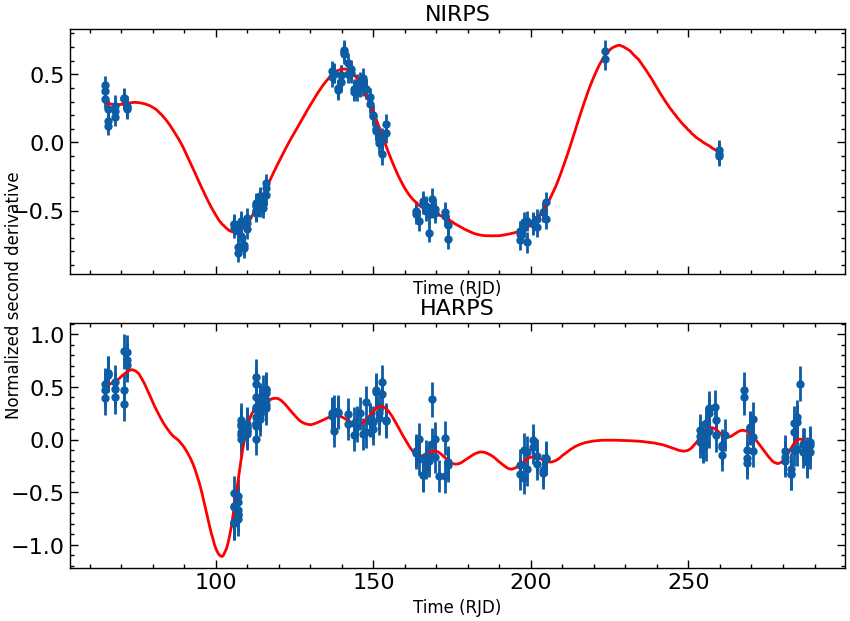

In [ ]:
fig, axes = plt.subplots(len(instruments), 1, figsize=(10, 7), sharex=True)
i = 0 #id of instrument

for instrument in instruments: 
    # Times
    min_time, max_time = np.min(data.times_rv[instrument]), np.max(data.times_rv[instrument])
    model_times = np.linspace(min_time,max_time,1000)

    # GP model
    full_model, components = results.rv.evaluate(instrument, t = model_times, GPregressors = model_times, return_components = True) # Keplerian model
    gp = results.rv.model[instrument]['GP'] # GP model
    
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument]) # White noise
    mu = np.median(results.posteriors['posterior_samples']['mu_'+instrument]) # Mean
    
    # Plotting
    if len(instruments)==1: 
        axes.errorbar(t_rv[instrument], d2v[instrument]-mu,
                      yerr=np.sqrt(sd2v[instrument]**2+jitter**2), fmt='o', label = f'{instrument} data')
        axes.plot(model_times, gp, label = f'GP {instrument}',color='red')
        axes.set_xlabel("Time (RJD)", fontsize = 12)
        axes.set_title(f"{instrument}")
    
    else:
        axes[i].errorbar(t_rv[instrument], d2v[instrument]-mu,
                      yerr=np.sqrt(sd2v[instrument]**2+jitter**2), fmt='o', label = f'{instrument} data')
        axes[i].plot(model_times, gp, label = f'GP {instrument}',color='red')
        axes[i].set_xlabel("Time (RJD)", fontsize = 12)
        axes[i].set_title(f"{instrument}")

    i+=1

# Add a common y-label for both y-axes
fig.text(0.06, 0.5, 'Normalized second derivative', fontsize =12, va='center', rotation='vertical')

plt.savefig(f'stars/{star}/juliet/output_{star}_d2v_GP/{star}_d2v_GP_curve.png')
plt.show()

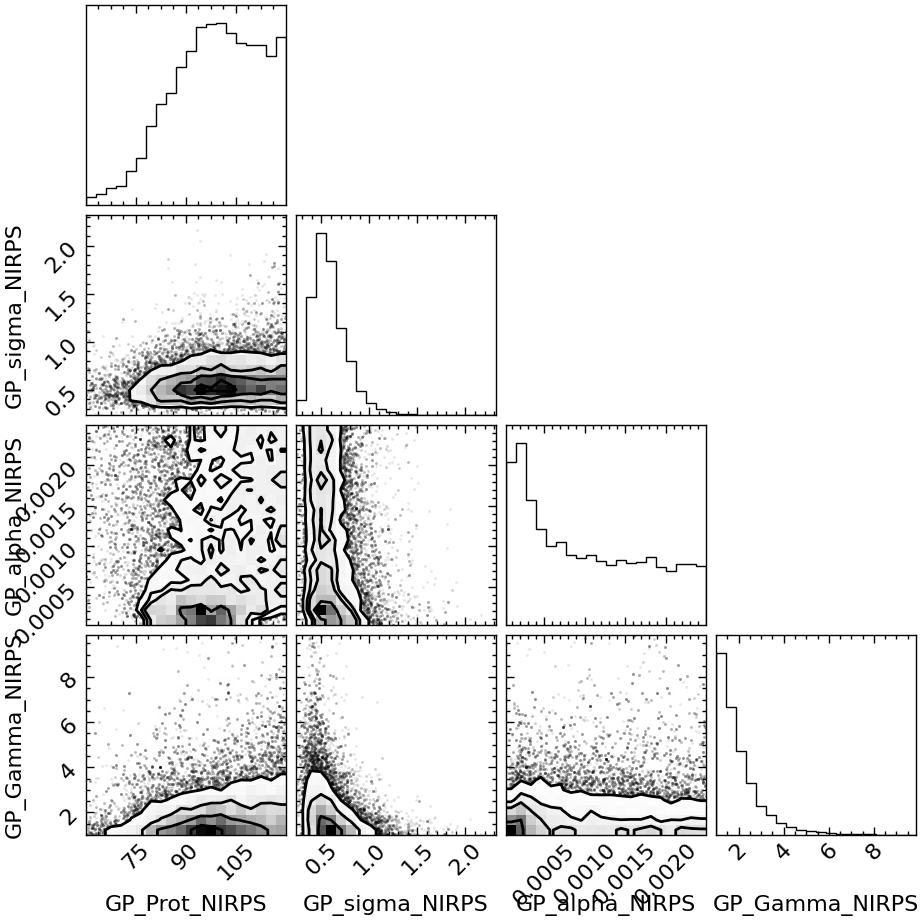

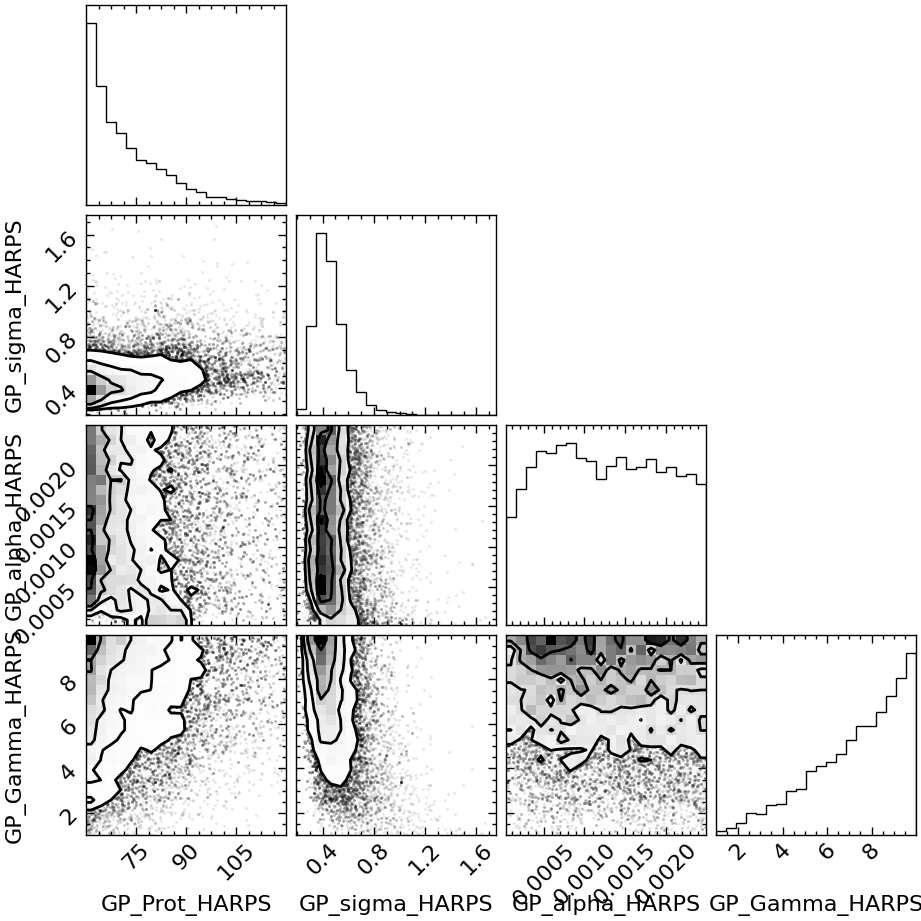

In [ ]:
num_params_per_instrument = 6
posterior_names = {}
start = 0 

n=0
for instrument in instruments: 
    posterior_names[instrument] = []
    posterior_names[instrument].extend(name['name'] + '_' + instrument for name in paramsGP_act)
    first_time = True
    
    for i in range(start, (n+1)*(num_params_per_instrument)):
        if dists[i] != 'fixed' and 'mu' not in params[i] and 'w' not in params[i] and \
        params[i][0:2] != 'mu' and params[i][0:5] != 'sigma':
            if first_time:
                posterior_data = results.posteriors['posterior_samples'][params[i]]
                first_time = False
            else:
                posterior_data  = np.vstack((posterior_data, results.posteriors['posterior_samples'][params[i]]))
    posterior_data = posterior_data.T
    figure = corner.corner(posterior_data, labels = posterior_names[instrument])
    plt.savefig(f'stars/{star}/juliet/output_{star}_d2v_GP/{instrument}_{star}_d2v_GP_corner.png')
    plt.show()
    
    start += num_params_per_instrument
    
    n+=1

##### Dtemp

In [ ]:
print('Running Dtemp GP...')
#Dtemp
overwrite = True

# Overwrite output folder
out_folder = "stars/{}/juliet/output_{}_Dtemp_GP".format(star, star)

if overwrite:
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder)
        
    else: 
        pass

# Creating the juliet priors from the cell above
parameters = params_def_act + paramsGP_act
params, dists, hyperps = nirps.create_priors(parameters, instruments = instruments)

# Creating the prior dictionary to be loaded into juliet model
priors = juliet.generate_priors(params, dists, hyperps)

Gp_regressors = {}
for instrument in instruments: 
    Gp_regressors[instrument] = t_rv[instrument].copy()

# Run juliet:
data = juliet.load(priors = priors, t_rv = t_rv, y_rv = Dtemp, yerr_rv = sDtemp, GP_regressors_rv=Gp_regressors,
                out_folder = out_folder)


Running Dtemp GP...


In [ ]:
results = data.fit(n_live_points = 1000, nthread=6)

In [ ]:
posteriors = pd.read_table(f'stars/{star}/juliet/output_{star}_Dtemp_GP/posteriors.dat')
print(posteriors)

  # Parameter Name           Median         .1   Upper 68 CI    .2  \
0   mu_HARPS                      0.105430            1.275418       
1   sigma_w_HARPS                 4.071278            0.364918       
2   GP_Prot_HARPS                75.787172           24.354904       
3   GP_sigma_HARPS                3.409111            1.752863       
4   GP_alpha_HARPS                0.001307            0.000845       
5   GP_Gamma_HARPS                6.292147            2.570931       

    Lower 68 CI   
0       1.495263  
1       0.325352  
2      12.312864  
3       1.169470  
4       0.000846  
5       3.347812  


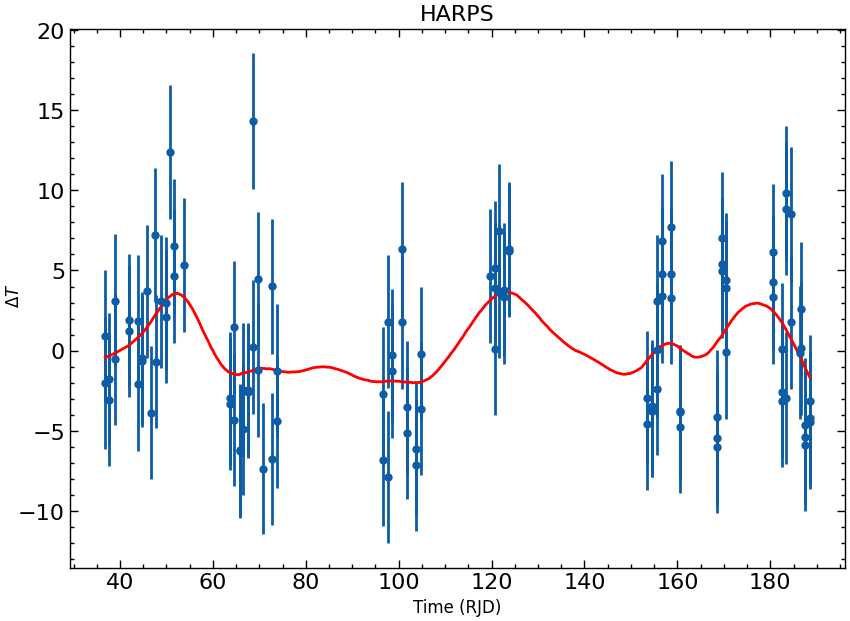

In [ ]:
fig, axes = plt.subplots(len(instruments), 1, figsize=(10, 7), sharex=True)
i = 0 #id of instrument

for instrument in instruments: 
    # Times
    min_time, max_time = np.min(data.times_rv[instrument]), np.max(data.times_rv[instrument])
    model_times = np.linspace(min_time,max_time,1000)

    # GP model
    full_model, components = results.rv.evaluate(instrument, t = model_times, GPregressors = model_times, return_components = True) # Keplerian model
    gp = results.rv.model[instrument]['GP'] # GP model
    
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument]) # White noise
    mu = np.median(results.posteriors['posterior_samples']['mu_'+instrument]) # Mean
    
    # Plotting
    if len(instruments)==1: 
        axes.errorbar(t_rv[instrument], Dtemp[instrument]-mu,
                      yerr=np.sqrt(sDtemp[instrument]**2 + jitter**2),
                      fmt='o', label = f'{instrument} data')
        axes.plot(model_times, gp, label = f'GP {instrument}',color='red')
        axes.set_xlabel("Time (RJD)", fontsize = 12)
        axes.set_title(f"{instrument}")
    else: 
        axes[i].errorbar(t_rv[instrument], Dtemp[instrument]-mu,
                         yerr=np.sqrt(sDtemp[instrument]**2 + jitter**2),
                         fmt='o', label = f'{instrument} data')
        axes[i].plot(model_times, gp, label = f'GP {instrument}',color='red')
        axes[i].set_xlabel("Time (RJD)", fontsize = 12)
        axes[i].set_title(f"{instrument}")

    i+=1

    
# Add a common y-label for both y-axes
fig.text(0.06, 0.5, r'$\Delta T$', fontsize =12, va='center', rotation='vertical')

plt.savefig(f'stars/{star}/juliet/output_{star}_Dtemp_GP/{star}_Dtemp_GP_curve.png')
plt.show()

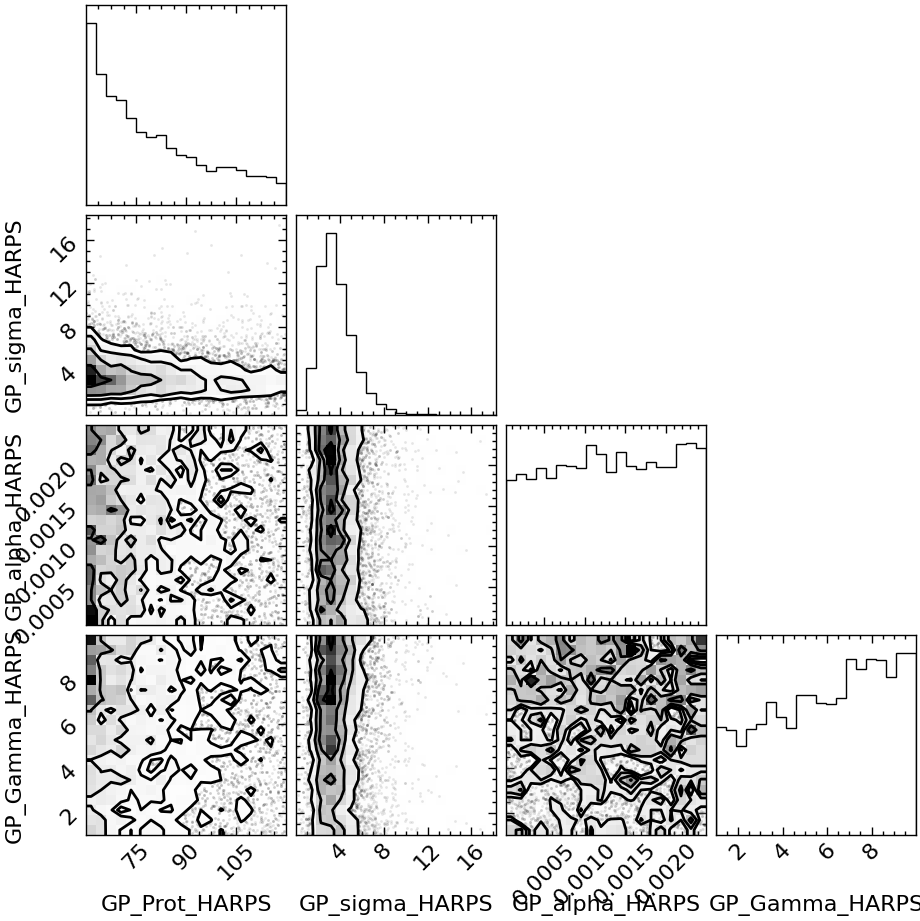

In [ ]:
num_params_per_instrument = 6
posterior_names = {}
start = 0 
n=0

for instrument in instruments: 
    posterior_names[instrument] = []
    posterior_names[instrument].extend(name['name'] + '_' + instrument for name in paramsGP_act)
    first_time = True
    
    for i in range(start, (n+1)*(num_params_per_instrument)):
        if dists[i] != 'fixed' and 'mu' not in params[i] and 'w' not in params[i] and \
        params[i][0:2] != 'mu' and params[i][0:5] != 'sigma':
            if first_time:
                posterior_data = results.posteriors['posterior_samples'][params[i]]
                first_time = False
            else:
                posterior_data  = np.vstack((posterior_data, results.posteriors['posterior_samples'][params[i]]))
    posterior_data = posterior_data.T
    figure = corner.corner(posterior_data, labels = posterior_names[instrument])
    plt.savefig(f'stars/{star}/juliet/output_{star}_Dtemp_GP/{instrument}_{star}_Dtemp_GP_corner.png')
    plt.show()
    
    start += num_params_per_instrument
    n+=1


### 0 planet model + GP

Setting priors

### 0 planet + GP model

In [ ]:
# RVs 
# 0 planet + GP
print('Running 0 planet + GP...')
overwrite = True

# Overwrite output folder
out_folder = "stars/{}/juliet/output_{}_0_GP".format(star, star)

if overwrite:
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder)
        
    else: 
        pass

# Creating the juliet priors from the cell above
parameters = params_def_RV + paramsGP
params, dists, hyperps = nirps.create_priors(parameters, instruments = instruments)

# Creating the prior dictionary to be loaded into juliet model
priors = juliet.generate_priors(params, dists, hyperps)

Gp_regressors = {}
for instrument in instruments: 
    Gp_regressors[instrument] = t_rv[instrument].copy()

# Run juliet:
data = juliet.load(priors = priors, t_rv = t_rv, y_rv = y_rv, yerr_rv = yerr_rv, GP_regressors_rv=Gp_regressors,
                out_folder = out_folder)


Running 0 planet + GP...


In [ ]:
results = data.fit(n_live_points = 1000, nthread=6)

posteriors = pd.read_table('stars/{}/juliet/output_{}_0_GP/posteriors.dat'.format(star, star))
print(posteriors)

# Print log-evidence
print('0 planet + GP Log-evidence: {0:.3f} ± {1:.3f}'.format(results.posteriors['lnZ'],\
       results.posteriors['lnZerr']))

PyMultinest installation not detected. Forcing dynesty as the sampler.


13289it [10:00, 22.14it/s, +1000 | bound: 65 | nc: 1 | ncall: 288502 | eff(%):  4.970 | loglstar:   -inf < -269.323 <    inf | logz: -282.851 +/-    nan | dlogz:  0.001 >  1.009]


  # Parameter Name           Median         .1   Upper 68 CI    .2  \
0   mu_HARPS                      0.194010            2.809564       
1   sigma_w_HARPS                 1.477357            0.251767       
2   GP_Prot_HARPS                91.604023            3.306326       
3   GP_sigma_HARPS                6.544381            3.708535       
4   GP_alpha_HARPS                0.000065            0.000028       
5   GP_Gamma_HARPS                4.614356            3.339354       

    Lower 68 CI   
0       2.762780  
1       0.257552  
2       3.799399  
3       1.860464  
4       0.000025  
5       2.746092  
0 planet + GP Log-evidence: -282.851 ± 0.263


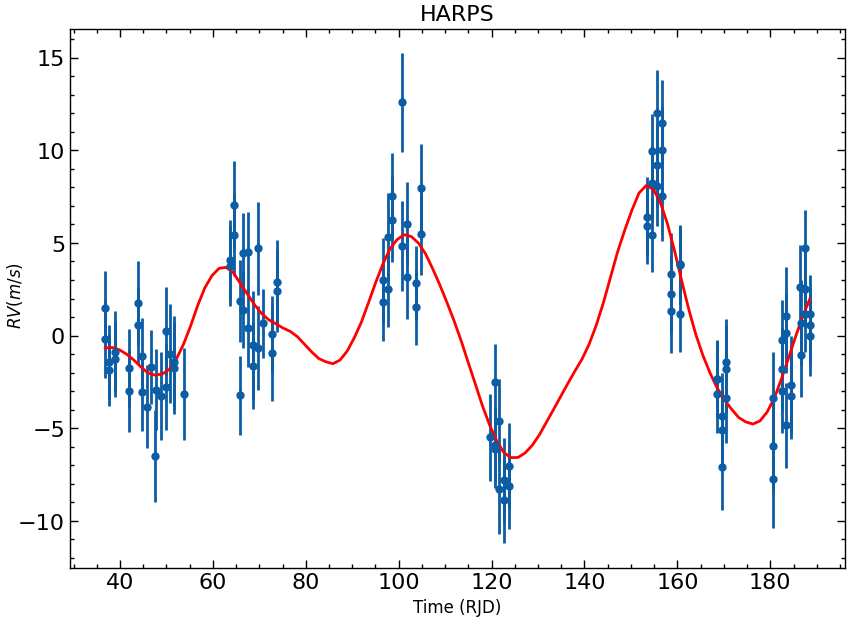

In [ ]:
fig, axes = plt.subplots(len(instruments), 1, figsize=(10, 7), sharex=True)
i = 0 #id of instrument

for instrument in instruments: 
    # Times
    min_time, max_time = np.min(data.times_rv[instrument]), np.max(data.times_rv[instrument])
    model_times = np.linspace(min_time,max_time,100)

    # GP model
    full_model, components = results.rv.evaluate(instrument, t = model_times, GPregressors = model_times, return_components = True) # Keplerian model
    gp = results.rv.model[instrument]['GP'] # GP model
    
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument]) # White noise
    mu = np.median(results.posteriors['posterior_samples']['mu_'+instrument]) # Mean

    # Plotting
    if len(instruments)==1: 
        axes.errorbar(t_rv[instrument], y_rv[instrument]-mu,
                      yerr=np.sqrt(yerr_rv[instrument]**2 + jitter**2),
                      fmt='o', label = f'{instrument} data')
        axes.plot(model_times, gp, label = f'GP {instrument}',color='red')
        axes.set_xlabel("Time (RJD)", fontsize = 12)
        axes.set_title(f"{instrument}")
    else:
        axes[i].errorbar(t_rv[instrument], y_rv[instrument]-mu,
                      yerr=np.sqrt(yerr_rv[instrument]**2 + jitter**2),
                      fmt='o', label = f'{instrument} data')
        axes[i].plot(model_times, gp, label = f'GP {instrument}',color='red')
        axes[i].set_xlabel("Time (RJD)", fontsize = 12)
        axes[i].set_title(f"{instrument}")

    i+=1

# Add a common y-label for both y-axes
fig.text(0.06, 0.5, r'$RV (m/s)$', fontsize =12, va='center', rotation='vertical')

plt.savefig(f'stars/{star}/juliet/output_{star}_0_GP/{star}_0_GP_curve.png')
plt.show()

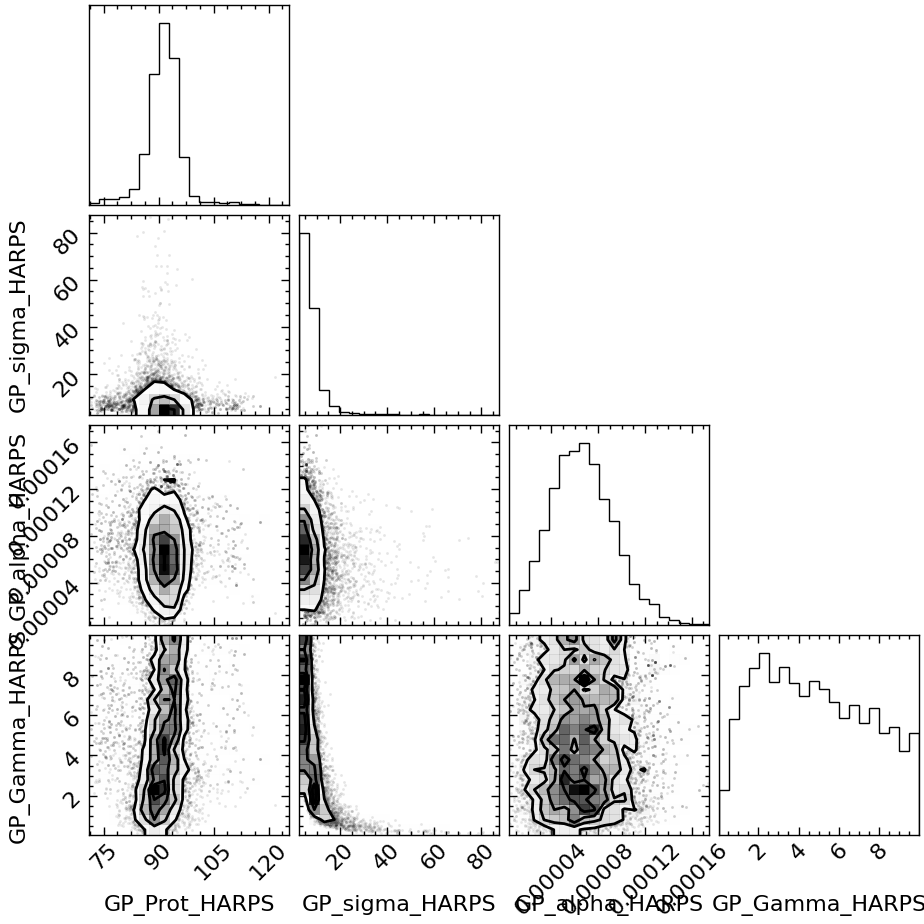

In [ ]:
num_params_per_instrument = 6
posterior_names = {}
start = 0 
n=0

for instrument in instruments: 
    posterior_names[instrument] = []
    posterior_names[instrument].extend(name['name'] + '_' + instrument for name in paramsGP)
    first_time = True
    
    for i in range(start, (n+1)*(num_params_per_instrument)):
        if dists[i] != 'fixed' and 'mu' not in params[i] and 'w' not in params[i] and \
        params[i][0:2] != 'mu' and params[i][0:5] != 'sigma':
            if first_time:
                posterior_data = results.posteriors['posterior_samples'][params[i]]
                first_time = False
            else:
                posterior_data  = np.vstack((posterior_data, results.posteriors['posterior_samples'][params[i]]))
    posterior_data = posterior_data.T
    figure = corner.corner(posterior_data, labels = posterior_names[instrument])
    plt.savefig(f'stars/{star}/juliet/output_{star}_0_GP/{instrument}_{star}_0_GP_corner.png')
    plt.show()
    
    start += num_params_per_instrument
    n+=1

### 1 planet model

In [ ]:
overwrite = True

# Overwrite output folder
out_folder = "stars/{}/juliet/output_{}_1".format(star, star)

if overwrite:
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder)
        
    else: 
        pass

# Creating the juliet priors from the cell above
parameters = params_def_RV + params_p1
paramsD, distsD, hyperpsD = nirps.create_priors(params_def_RV, instruments = instruments) #Default priors
paramsP, distsP, hyperpsP = nirps.create_planet_priors(params_p1) #Planet priors

params = paramsD + paramsP
dists = distsD + distsP
hyperps = hyperpsD + hyperpsP

# Creating the prior dictionary to be loaded into juliet model
priors = juliet.generate_priors(params, dists, hyperps)

# Loading the dataset
data = juliet.load(priors = priors, t_rv = t_rv, y_rv = y_rv, yerr_rv = yerr_rv, out_folder = out_folder)


Run the nested sampling analysis

In [ ]:
results = data.fit(n_live_points = 300)

posteriors = pd.read_table('stars/{}/juliet/output_{}_1/posteriors.dat'.format(star, star))
print(posteriors)

# Print log-evidence
print('Log-evidence: {0:.3f} ± {1:.3f}'.format(results.posteriors['lnZ'],\
       results.posteriors['lnZerr']))

PyMultinest installation not detected. Forcing dynesty as the sampler.


221it [00:00, 415.73it/s, bound: 0 | nc: 1 | ncall: 637 | eff(%): 34.694 | loglstar:   -inf < -547.412 <    inf | logz: -553.119 +/-  0.122 | dlogz: 220.582 >  0.309]

4449it [01:51, 39.86it/s, +300 | bound: 77 | nc: 1 | ncall: 95404 | eff(%):  4.993 | loglstar:   -inf < -320.582 <    inf | logz: -334.211 +/-  0.205 | dlogz:  0.001 >  0.309]


  # Parameter Name           Median         .1   Upper 68 CI    .2  \
0   mu_HARPS                      0.762890            0.402160       
1   sigma_w_HARPS                 4.034601            0.299403       
2   P_p1                         14.718368            0.357271       
3   K_p1                          2.672198            0.602675       
4   t0_p1                       192.163001            7.420887       

    Lower 68 CI   
0       0.449919  
1       0.293631  
2       2.208978  
3       0.615439  
4       1.260414  
Log-evidence: -334.211 ± 0.292


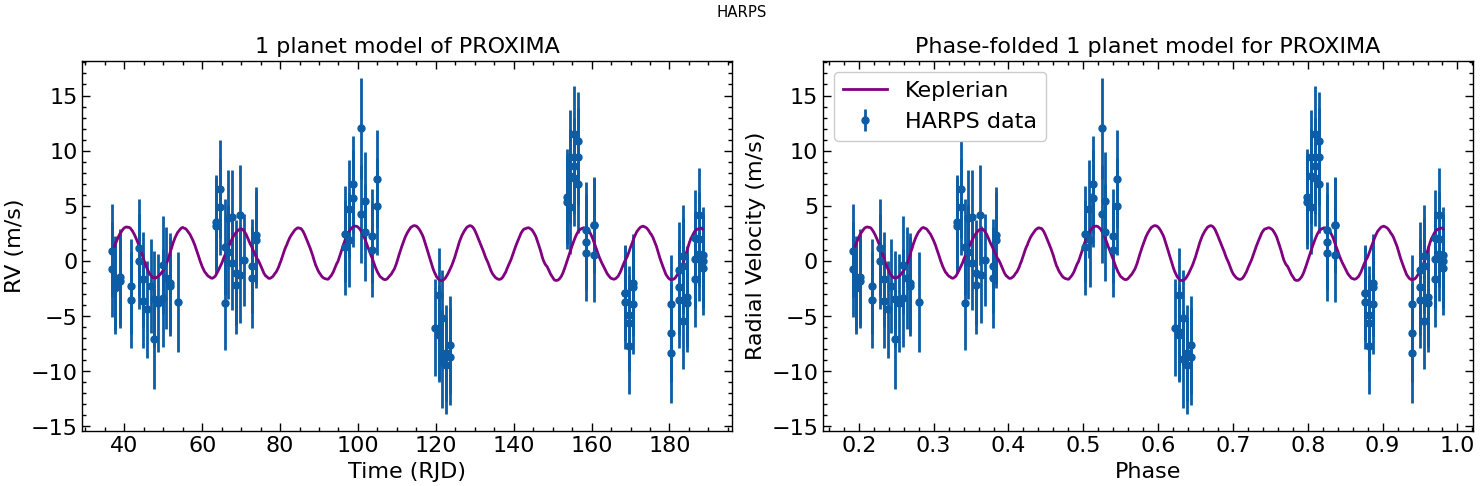

In [ ]:
period = posteriors[' Median       '][4] # Period for phase-folding

# Loop over instruments
for instrument in instruments:
    # Times
    min_time, max_time = np.min(data.times_rv[instrument]), np.max(data.times_rv[instrument])
    model_times = np.linspace(min_time, max_time, 1000)

    # GP model
    full_model, components = results.rv.evaluate(instrument, t=model_times,
                                                     GPregressors=model_times, return_components=True)

    mu = np.median(results.posteriors['posterior_samples']['mu_' + instrument])  # Mean
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_' + instrument])  # White noise
    
    # Plotting
    plt.figure(figsize=(15, 5))

    # Plot the RV data and model
    plt.subplot(1, 2, 1)
    plt.errorbar(t_rv[instrument], y_rv[instrument]-mu,
                 yerr=np.sqrt(yerr_rv[instrument]**2 + jitter**2)
                 , fmt='o', label = f'{instrument} data')
    plt.plot(model_times, full_model, label='Keplerian', color='purple')
    plt.xlabel("Time (RJD)")
    plt.ylabel(r"RV (m/s)")
    plt.title("1 planet model of {}".format(star))

    # Phase-fold the data 
    phases_data = (t_rv[instrument] % period) / period
    sorted_indices_data = np.argsort(phases_data)
    
    # Phase-fold the model
    phases_model = (model_times % period) / period
    sorted_indices_model = np.argsort(phases_model)

    # Plot the phase-folded RV data and model
    plt.subplot(1, 2, 2)
    plt.errorbar(phases_data[sorted_indices_data], y_rv[instrument][sorted_indices_data]-mu, 
                 yerr=np.sqrt(yerr_rv[instrument][sorted_indices_data]**2+jitter**2),
                                fmt='o', label=f'{instrument} data')
    plt.plot(phases_model[sorted_indices_model], full_model[sorted_indices_model], label='Keplerian', color='purple')
    plt.xlabel('Phase')
    plt.ylabel('Radial Velocity (m/s)')
    plt.title('Phase-folded 1 planet model for {}'.format(star))

    plt.suptitle(instrument)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'stars/{star}/juliet/output_{star}_1/{instrument}_{star}_1_curve.png')
    plt.show()

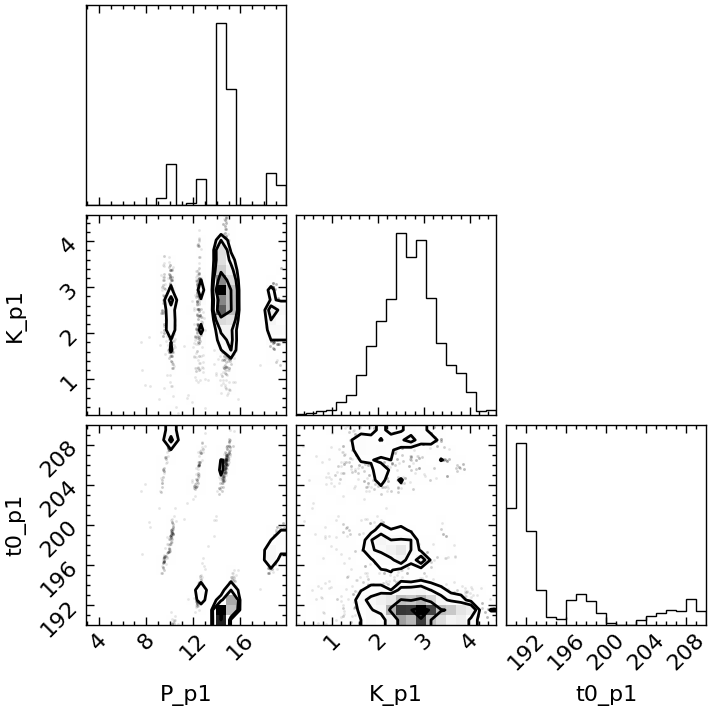

In [ ]:
posterior_names = ['P_p1', 'K_p1', 't0_p1']
    
first_time = True
for i in range(len(params)):
    if dists[i] != 'fixed' and 'mu' not in params[i] and 'w' not in params[i] and \
    params[i][0:2] != 'mu' and params[i][0:5] != 'sigma':
        if first_time:
            posterior_data = results.posteriors['posterior_samples'][params[i]]
            first_time = False
        else:
            posterior_data  = np.vstack((posterior_data, results.posteriors['posterior_samples'][params[i]]))
posterior_data = posterior_data.T
figure = corner.corner(posterior_data, labels = posterior_names)
plt.savefig('stars/{}/juliet/output_{}_1/{}_1_corner.png'.format(star, star, star))
plt.show()

### 1 planet + common GP model

In [15]:
print('Running 1 planet + 1 GP...')
overwrite = True

out_folder = "stars/{}/juliet/output_{}_1_1GP".format(star, star)

if overwrite:
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder)
    else: 
        pass

common_label = ''
for instrument in instruments:
    common_label += instrument

paramsD, distsD, hyperpsD = nirps.create_priors(params_def_RV, instruments=[common_label])  # Default priors
params_GP, dists_GP, hyperps_GP = nirps.create_priors(paramsGP, instruments=[common_label])  # GP priors
paramsP, distsP, hyperpsP = nirps.create_planet_priors(params_p1)  # Planet priors

params = paramsD + paramsP + params_GP
dists = distsD + distsP + dists_GP
hyperps = hyperpsD + hyperpsP + hyperps_GP

priors = juliet.generate_priors(params, dists, hyperps)

# Consolidate times
all_times = {}
all_times[common_label] = np.concatenate([t_rv[instrument] for instrument in instruments])  # Concatenate times

# Consolidate RVs
all_rvs = {}
all_rvs[common_label] = np.concatenate([y_rv[instrument] for instrument in instruments])  # Concatenate RVs

# Consolidate RV errors
all_rverrs = {}
all_rverrs[common_label] = np.concatenate([yerr_rv[instrument] for instrument in instruments])  # Concatenate RV errors

Gp_regressors = {}  # Consolidated regressors for both instruments
Gp_regressors[common_label] = all_times[common_label].copy()  # Use the same GP regressors for both instruments

data = juliet.load(
    priors=priors,
    t_rv=all_times,
    y_rv=all_rvs,
    yerr_rv=all_rverrs,
    GP_regressors_rv=Gp_regressors,  # Use consolidated regressors
    out_folder=out_folder)


Running 1 planet + 1 GP...


In [16]:
results = data.fit(n_live_points=1200, nthread=6, dynamic=True)

posteriors = pd.read_table(f'stars/{star}/juliet/output_{star}_1_1GP/posteriors.dat')
print(posteriors)

# Print log-evidence
print('Log-evidence: {0:.3f} ± {1:.3f}'.format(results.posteriors['lnZ'],\
       results.posteriors['lnZerr']))

PyMultinest installation not detected. Forcing dynesty as the sampler.


4246it [03:10,  8.61it/s, bound: 0 | nc: 15 | ncall: 41376 | eff(%): 10.262 | loglstar:   -inf < -551.087 <    inf | logz: -557.743 +/-  0.068 | dlogz: 154768.964 >  1.209] 

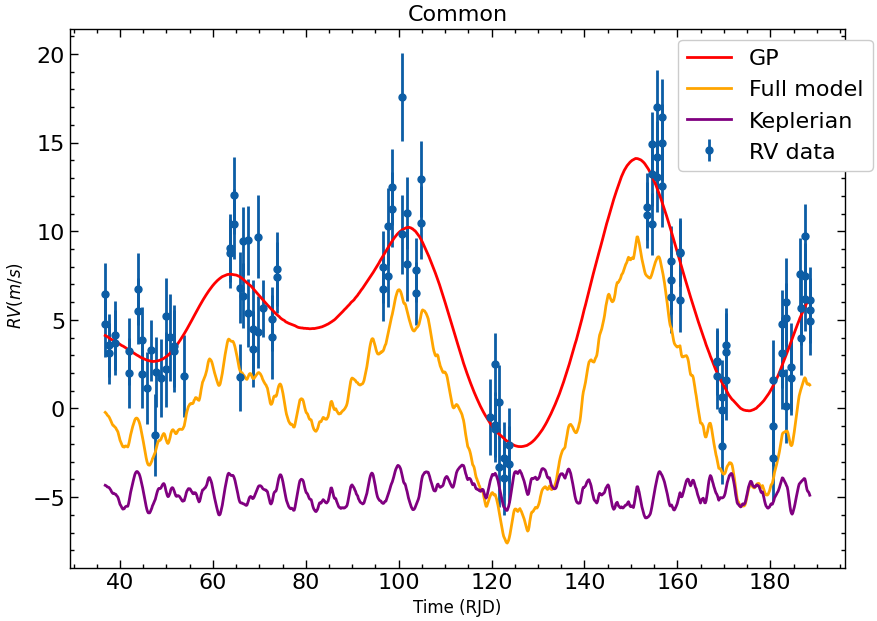

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7), sharex=True)

min_time, max_time = np.min(data.times_rv[common_label]), np.max(data.times_rv[common_label])
model_times = np.linspace(min_time, max_time, 1000)

full_model, components = results.rv.evaluate(
    common_label, t=model_times, GPregressors=model_times, return_components=True
)
gp = results.rv.model[common_label]['GP']
#keplerian = results.rv.model[common_label]['deterministic']
keplerian = full_model - gp

mu = np.median(results.posteriors['posterior_samples']['mu_' + common_label])
jitter = np.median(results.posteriors['posterior_samples']['sigma_w_' + common_label])


axes.errorbar(
    all_times[common_label], all_rvs[common_label]-mu,
    yerr=np.sqrt(all_rverrs[common_label]**2+jitter**2),
    fmt='o', label=f'RV data'
)
axes.plot(model_times, gp, label=f'GP', color='red')
axes.plot(model_times, full_model, label=f'Full model', color='orange')
axes.plot(model_times, keplerian, label=f'Keplerian', color='purple')
axes.set_xlabel("Time (RJD)", fontsize=12)
axes.set_title(f"Common")

i += 1

plt.legend(bbox_to_anchor=(1.05, 1))
fig.text(0.06, 0.5, r'$RV (m/s)$', fontsize=12, va='center', rotation='vertical')

plt.savefig(f'stars/{star}/juliet/output_{star}_1_1GP/{star}_1_1GP_curve.png')
plt.show()

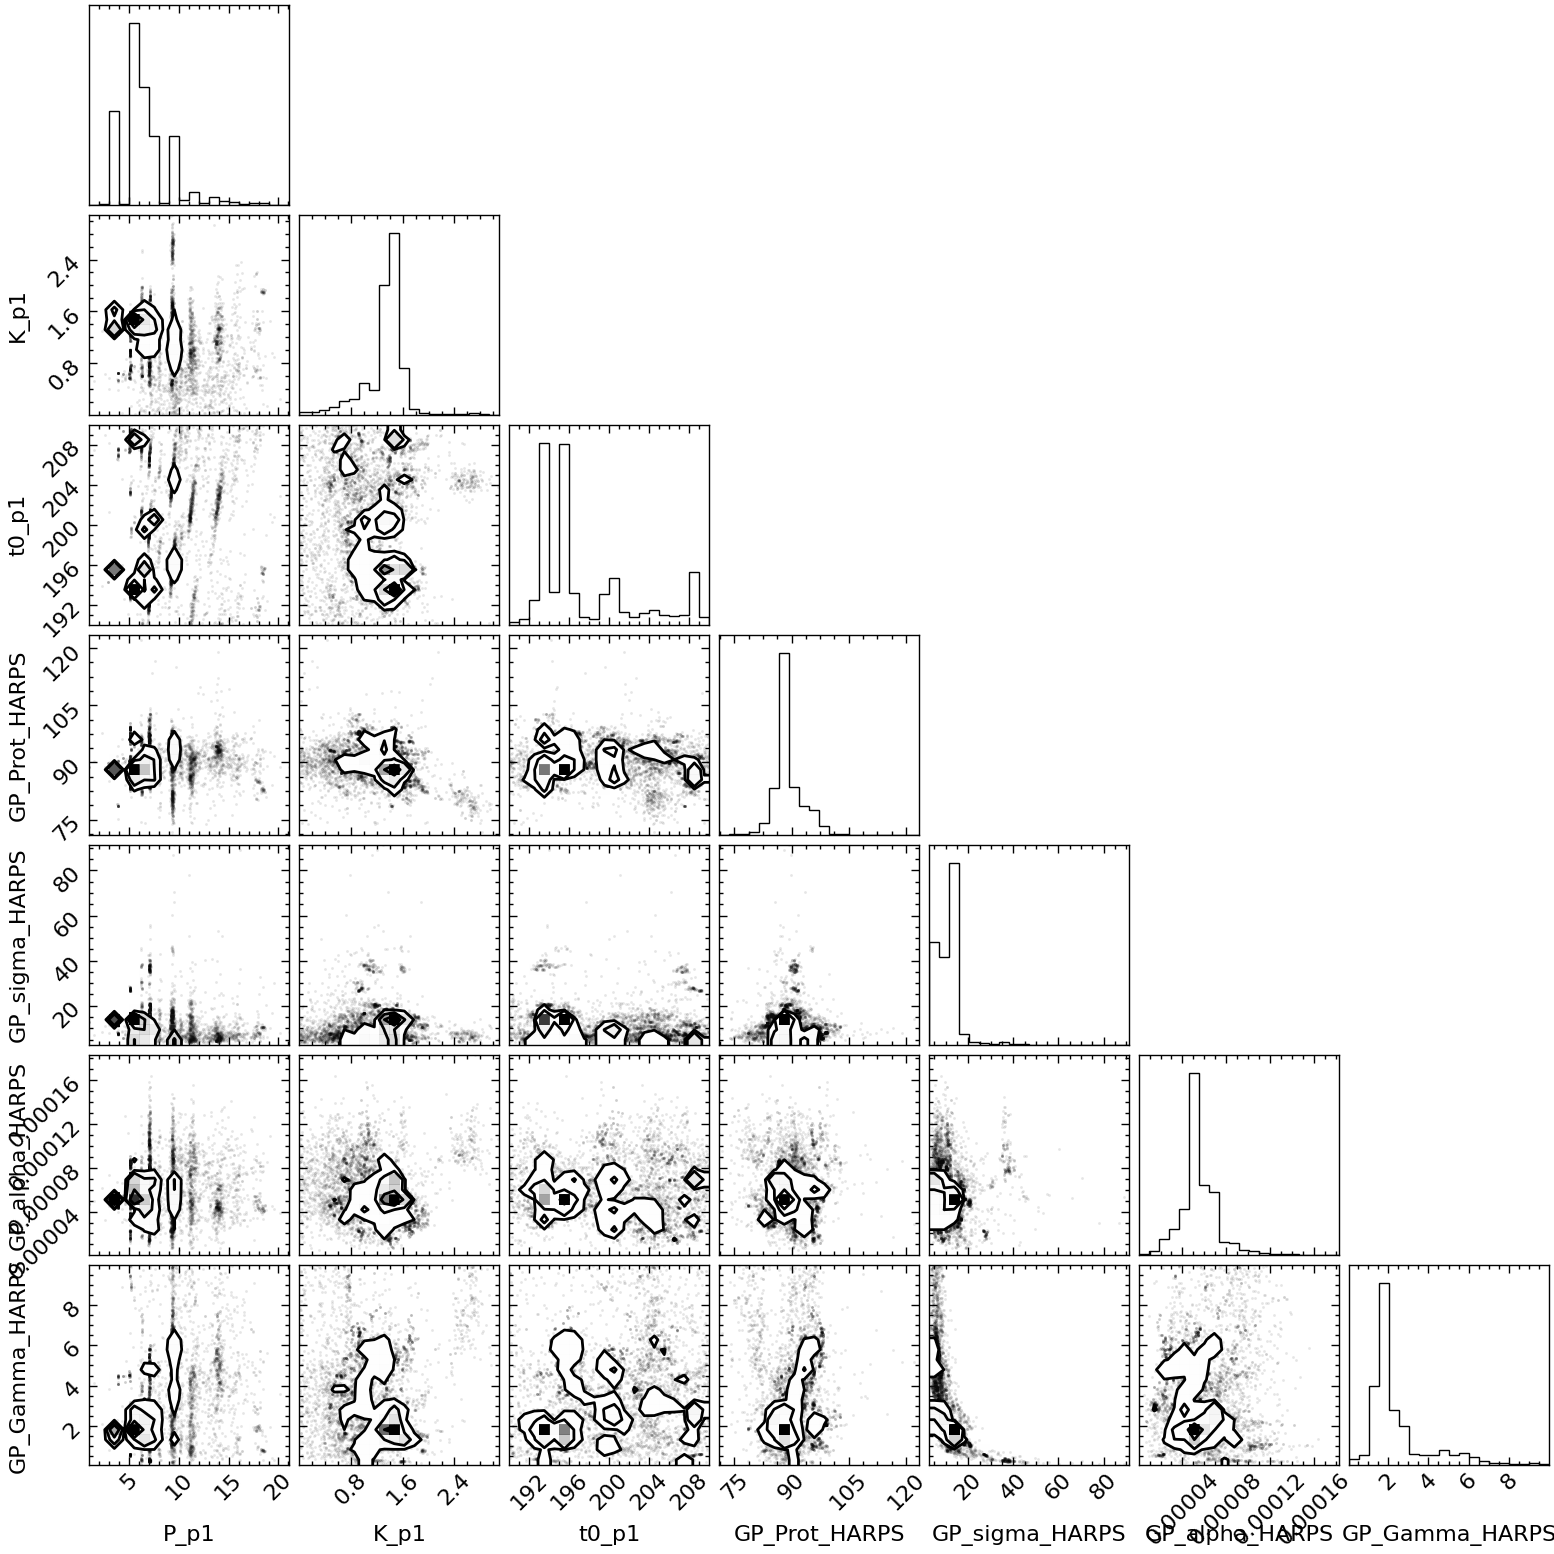

In [ ]:
posterior_names = ['P_p1', 'K_p1', 't0_p1'] + params_GP  # Update the GP parameters here
posterior_data = []

for i in range(len(params)):
    if dists[i] != 'fixed' and 'mu' not in params[i] and 'w' not in params[i] \
    and params[i][0:2] != 'mu' and params[i][0:5] != 'sigma':
        posterior_data.append(results.posteriors['posterior_samples'][params[i]])

posterior_data = np.array(posterior_data).T

corner_params = []  # Fewer GP parameters for corner plot
for par in posterior_names:
    if par not in ['gp_explength', 'gp_per', 'gp_perlength']:
        corner_params.append(par)

figure = corner.corner(
    posterior_data, labels=corner_params  # Use the updated GP parameters here
)
plt.savefig(f'stars/{star}/juliet/output_{star}_1_1GP/{star}_1_1GP_corner.png')
plt.show()

### 1 planet + separate GPs

In [7]:
print('Running 1 planet + 2 GP...')

overwrite = True
# Overwrite output folder
out_folder = "stars/{}/juliet/output_{}_1_2GP".format(star, star)

if overwrite:
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder)
        
    else: 
        pass

# Creating the juliet priors from the cell above
paramsD, distsD, hyperpsD = nirps.create_priors(params_def_RV, instruments = instruments) #Default priors
params_GP, dists_GP, hyperps_GP = nirps.create_priors(paramsGP, instruments = instruments) #GP priors
paramsP, distsP, hyperpsP = nirps.create_common_priors(params_p1) #Planet priors

params = paramsD + paramsP + params_GP
dists = distsD + distsP + dists_GP
hyperps = hyperpsD + hyperpsP + hyperps_GP

# Creating the prior dictionary to be loaded into juliet model
priors = juliet.generate_priors(params, dists, hyperps)

Gp_regressors = {}
for instrument in instruments: 
    Gp_regressors[instrument] = t_rv[instrument].copy()


# Loading the dataset
data = juliet.load(priors = priors, t_rv = t_rv, y_rv = y_rv, yerr_rv = yerr_rv, GP_regressors_rv = Gp_regressors,
                   out_folder = out_folder)


Running 1 planet + 2 GP...


In [6]:
results = data.fit(n_live_points = 1500, nthread=6, dynamic=True)

posteriors = pd.read_table('stars/{}/juliet/output_{}_1_2GP/posteriors.dat'.format(star, star))
print(posteriors)


# Print log-evidence
print('1 planet + 2 GP Log-evidence: {0:.3f} ± {1:.3f}'.format(results.posteriors['lnZ'],\
       results.posteriors['lnZerr']))

PyMultinest installation not detected. Forcing dynesty as the sampler.


6348it [11:37,  4.24it/s, bound: 5 | nc: 35 | ncall: 89472 | eff(%):  7.095 | loglstar:   -inf < -1083.949 <    inf | logz: -1091.340 +/-  0.065 | dlogz: 40766.888 >  1.509] 

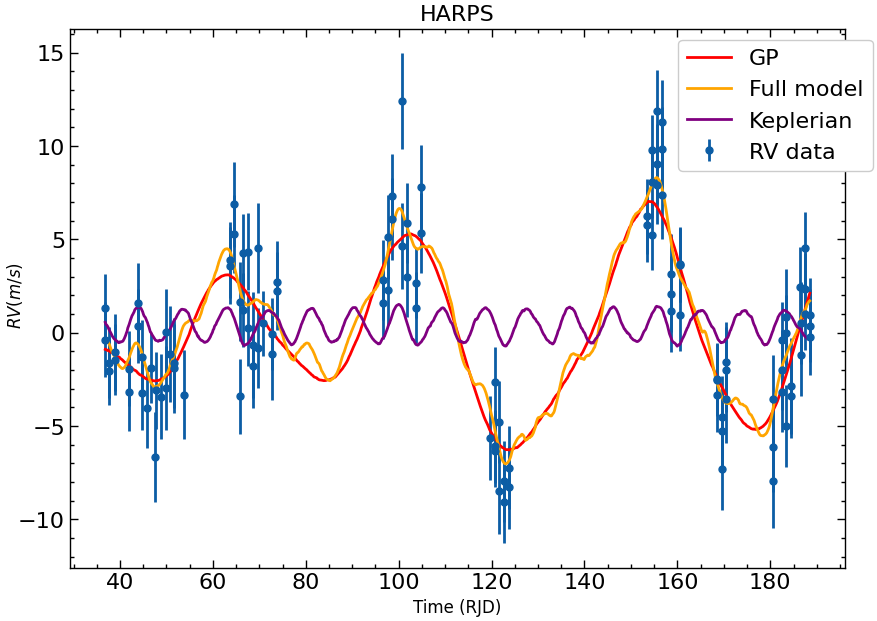

In [ ]:
fig, axes = plt.subplots(len(instruments), 1, figsize=(10, 7), sharex=True)
i = 0 #id of instrument

for instrument in instruments: 
    # Times
    min_time, max_time = np.min(data.times_rv[instrument]), np.max(data.times_rv[instrument])
    model_times = np.linspace(min_time,max_time,1000)

    # GP model
    full_model, components = results.rv.evaluate(instrument, t = model_times, GPregressors = model_times, return_components = True) # Keplerian model
    gp = results.rv.model[instrument]['GP'] # GP model
    keplerian = results.rv.model[instrument]['deterministic'] # Keplerian model
    
    mu = np.median(results.posteriors['posterior_samples']['mu_' + instrument])  # Mean
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_' + instrument])  # White noise
    

    # Plotting
    if len(instruments)==1: 
        axes.errorbar(t_rv[instrument], y_rv[instrument]-mu,
                      yerr=np.sqrt(yerr_rv[instrument]**2+jitter**2),
                      fmt='o', label = f'RV data')
        axes.plot(model_times, gp, label = f'GP',color='red')
        axes.plot(model_times, full_model, label = f'Full model', color='orange')
        axes.plot(model_times, keplerian, label = f'Keplerian', color='purple')
        axes.set_xlabel("Time (RJD)", fontsize = 12)
        axes.set_title(f"{instrument}")
    else:
        axes[i].errorbar(t_rv[instrument], y_rv[instrument]-mu,
                      yerr=np.sqrt(yerr_rv[instrument]**2+jitter**2),
                      fmt='o', label = f'RV data')
        axes[i].plot(model_times, gp, label = f'GP',color='red')
        axes[i].plot(model_times, full_model, label = f'Full model', color='orange')
        axes[i].plot(model_times, keplerian, label = f'Keplerian', color='purple')
        axes[i].set_xlabel("Time (RJD)", fontsize = 12)
        axes[i].set_title(f"{instrument}")

    i+=1

plt.legend(bbox_to_anchor=(1.05,1))
fig.text(0.06, 0.5, r'$RV (m/s)$', fontsize =12, va='center', rotation='vertical')

plt.savefig(f'stars/{star}/juliet/output_{star}_1_2GP/{star}_1_2GP_curve.png')
plt.show()

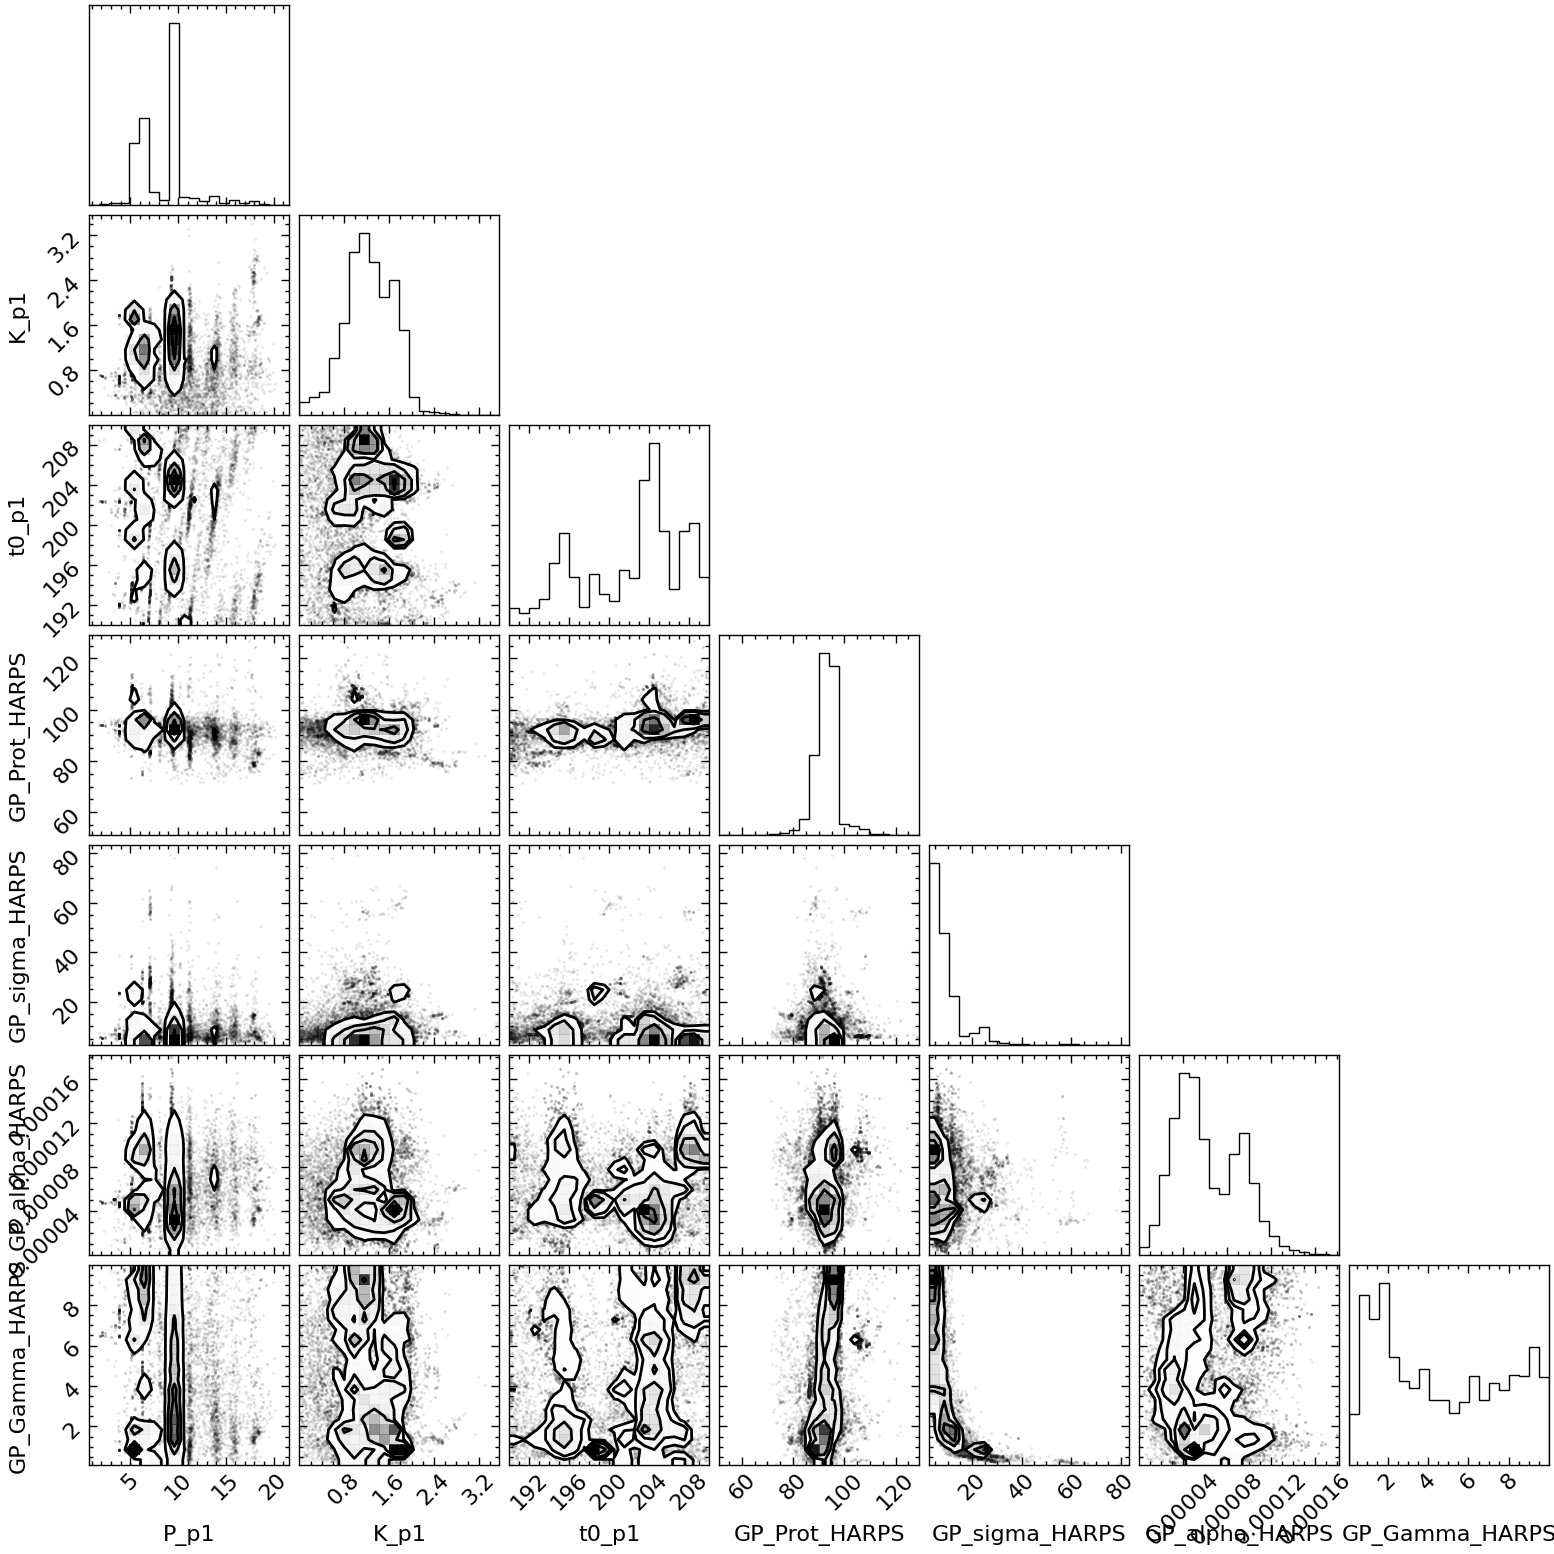

In [ ]:
posterior_names = ['P_p1', 'K_p1', 't0_p1'] + params_GP
    
first_time = True
for i in range(len(params)):
    if dists[i] != 'fixed' and 'mu' not in params[i] and 'w' not in params[i] and \
    params[i][0:2] != 'mu' and params[i][0:5] != 'sigma':
        if first_time:
            posterior_data = results.posteriors['posterior_samples'][params[i]]
            first_time = False
        else:
            posterior_data  = np.vstack((posterior_data, results.posteriors['posterior_samples'][params[i]]))
posterior_data = posterior_data.T
figure = corner.corner(posterior_data, labels = posterior_names)
plt.savefig('stars/{}/juliet/output_{}_1_2GP/{}_1_2GP_corner.png'.format(star, star, star))

### 2 planets model

In [ ]:
overwrite = True

# Overwrite output folder
out_folder = "stars/{}/juliet/output_{}_2".format(star, star)

if overwrite:
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder)
        
    else: 
        pass

# Creating the juliet priors from the cell above
parameters = params_def_RV + params_p1 + params_p2
paramsD, distsD, hyperpsD = nirps.create_priors(params_def_RV, instruments = instruments) #Default priors
paramsP1, distsP1, hyperpsP1 = nirps.create_planet_priors(params_p1) #First planet priors
paramsP2, distsP2, hyperpsP2 = nirps.create_planet_priors(params_p2) #Second planet priors

params = paramsD + paramsP1 + paramsP2
dists = distsD + distsP1 + distsP2
hyperps = hyperpsD + hyperpsP1 + hyperpsP2

# Creating the prior dictionary to be loaded into juliet model
priors = juliet.generate_priors(params, dists, hyperps)

# Loading the dataset
data = juliet.load(priors = priors, t_rv = t_rv, y_rv = y_rv, yerr_rv = yerr_rv, out_folder = out_folder)

NameError: name 'params_p2' is not defined

In [ ]:
results = data.fit(n_live_points = 1500)

posteriors = pd.read_table(f'stars/{star}/juliet/output_{star}_2/posteriors.dat')
print(posteriors)

PyMultinest installation not detected. Forcing dynesty as the sampler.


17922it [04:53, 61.16it/s, +1500 | bound: 62 | nc: 1 | ncall: 407532 | eff(%):  4.783 | loglstar:   -inf < -19.658 <    inf | logz: -32.127 +/-    nan | dlogz:  0.001 >  1.509]


  # Parameter Name           Median         .1   Upper 68 CI    .2  \
0   mu_HARPS                      0.842190            0.533835       
1   sigma_w_HARPS                 0.800614            0.838134       
2   P_p1                         16.168338           10.677113       
3   K_p1                          2.498038            0.239460       
4   t0_p1                        61.476091           25.932155       
5   P_p2                         47.969951            7.346993       
6   K_p2                          1.538321            2.609608       
7   t0_p2                        39.335963           45.014090       

    Lower 68 CI   
0       1.991345  
1       0.799393  
2       0.202913  
3       1.106879  
4      18.039301  
5      11.270856  
6       0.057976  
7      17.235283  


In [ ]:
# Print log-evidence
print('Log-evidence: {0:.3f} ± {1:.3f}'.format(results.posteriors['lnZ'],\
       results.posteriors['lnZerr']))

Log-evidence: -32.127 ± 0.264


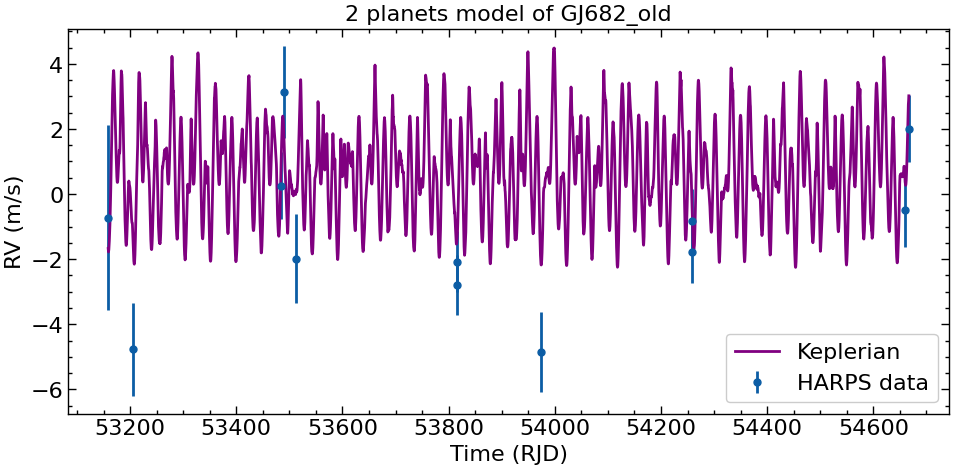

In [ ]:
# Loop over instruments
for instrument in instruments:
    # Times
    min_time, max_time = np.min(data.times_rv[instrument]), np.max(data.times_rv[instrument])
    model_times = np.linspace(min_time, max_time, 5000)

    # GP model
    full_model, components = results.rv.evaluate(instrument, t=model_times,
                                                     GPregressors=model_times, return_components=True)

    mu = np.median(results.posteriors['posterior_samples']['mu_' + instrument])  # Mean
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_' + instrument])  # White noise
    
    # Plotting
    plt.figure(figsize=(25, 5))

    # Plot the RV data and model
    plt.subplot(1, 2, 1)
    plt.errorbar(t_rv[instrument], y_rv[instrument]-mu,
                 yerr=np.sqrt(yerr_rv[instrument]**2 + jitter**2),
                 fmt='o', label = f'{instrument} data')
    plt.plot(model_times, full_model, label='Keplerian', color='purple')
    plt.xlabel("Time (RJD)")
    plt.ylabel(r"RV (m/s)")
    plt.title("2 planets model of {}".format(star))

    plt.legend()
    
    plt.savefig(f'stars/{star}/juliet/output_{star}_2/{instrument}_{star}_2_curve.png')

  # Parameter Name           Median         .1   Upper 68 CI    .2  \
0   mu_HARPS                      0.842190            0.533835       
1   sigma_w_HARPS                 0.800614            0.838134       
2   P_p1                         16.168338           10.677113       
3   K_p1                          2.498038            0.239460       
4   t0_p1                        61.476091           25.932155       
5   P_p2                         47.969951            7.346993       
6   K_p2                          1.538321            2.609608       
7   t0_p2                        39.335963           45.014090       

    Lower 68 CI   
0       1.991345  
1       0.799393  
2       0.202913  
3       1.106879  
4      18.039301  
5      11.270856  
6       0.057976  
7      17.235283  


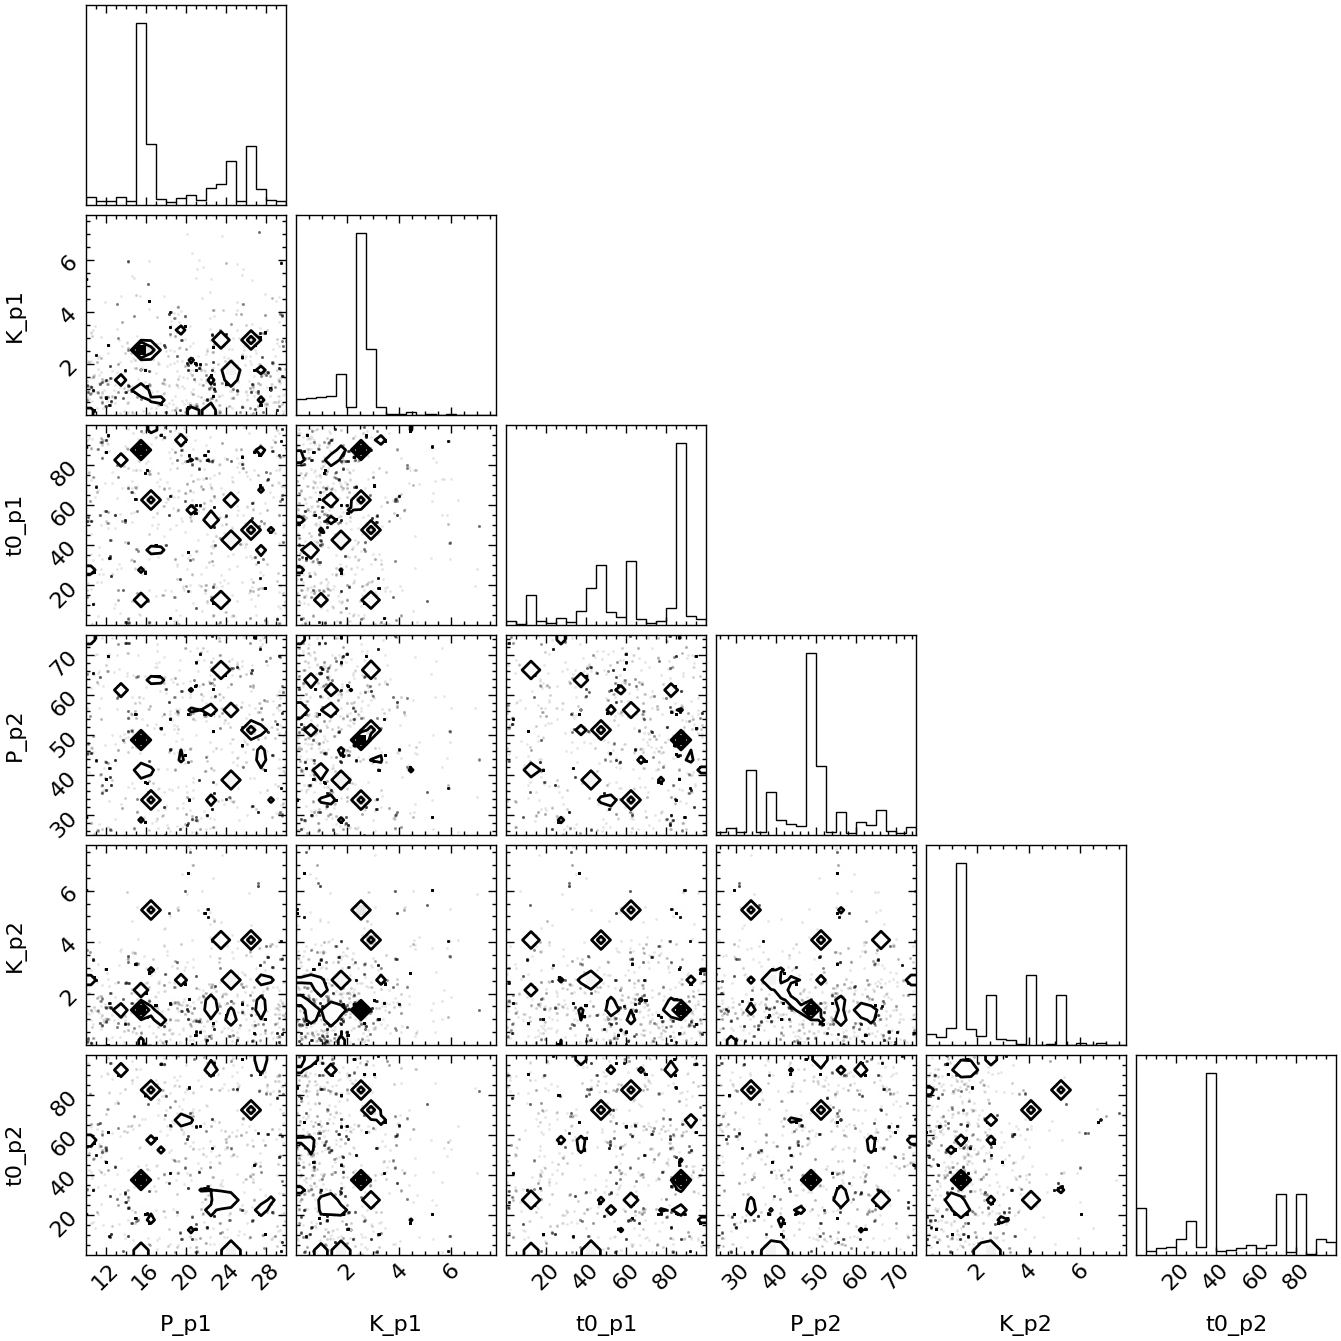

In [ ]:
posterior_names = ['P_p1', 'K_p1', 't0_p1'] + ['P_p2', 'K_p2', 't0_p2']
    
first_time = True
for i in range(len(params)):
    if dists[i] != 'fixed' and 'mu' not in params[i] and 'w' not in params[i] and \
    params[i][0:2] != 'mu' and params[i][0:5] != 'sigma':
        if first_time:
            posterior_data = results.posteriors['posterior_samples'][params[i]]
            first_time = False
        else:
            posterior_data  = np.vstack((posterior_data, results.posteriors['posterior_samples'][params[i]]))
posterior_data = posterior_data.T
figure = corner.corner(posterior_data, labels = posterior_names)
plt.savefig(f'stars/{star}/juliet/output_{star}_2/{star}_2_corner.png')

print(posteriors)

### 2 planets + GP model

In [ ]:
overwrite = True

# Overwrite output folder
out_folder = "stars/{}/juliet/output_{}_2_GP".format(star, star)

if overwrite:
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder)
        
    else: 
        pass

# Creating the juliet priors from the cell above
paramsD, distsD, hyperpsD = nirps.create_priors(params_def_RV, instruments = instruments) #Default priors
params_GP, dists_GP, hyperps_GP = nirps.create_priors(paramsGP, instruments = instruments) #GP priors
paramsP1, distsP1, hyperpsP1 = nirps.create_planet_priors(params_p1) # First planet priors
paramsP2, distsP2, hyperpsP2 = nirps.create_planet_priors(params_p2) # Second planet priors

params = paramsD + paramsP1 + paramsP2 + params_GP
dists = distsD + distsP1 + distsP2 + dists_GP
hyperps = hyperpsD + hyperpsP1 + hyperpsP2 + hyperps_GP

# Creating the prior dictionary to be loaded into juliet model
priors = juliet.generate_priors(params, dists, hyperps)

Gp_regressors = {}
for instrument in instruments: 
    Gp_regressors[instrument] = t_rv[instrument].copy()


# Loading the dataset
data = juliet.load(priors = priors, t_rv = t_rv, y_rv = y_rv, yerr_rv = yerr_rv, GP_regressors_rv = Gp_regressors,
                   out_folder = out_folder)

In [ ]:
results = data.fit(n_live_points = 1000, nthread=6, dynamic=True)

print(posteriors)

PyMultinest installation not detected. Forcing dynesty as the sampler.


iter: 309 | bound: 0 | nc: 1 | ncall: 1374 | eff(%): 22.489 | loglstar:   -inf < -461.828 <    inf | logz: -466.539 +/-    nan | dlogz: 77.956 >  1.009                                               

iter: 18363 | +1000 | bound: 105 | nc: 1 | ncall: 539493 | eff(%):  3.596 | loglstar:   -inf < -362.910 <    inf | logz: -381.641 +/-    nan | dlogz:  0.001 >  1.009                                 

# Parameter Name           Median         .1   Upper 68 CI    .2  \
0    P_p1                         10.562357            1.219352       
1    K_p1                          0.092167            0.220093       
2    t0_p1                     60153.114186           10.400553       
3    P_p2                         69.590023           13.800173       
4    K_p2                          0.013774            0.148444       
5    t0_p2                     60155.622229            4.661410       
6    GP_Prot_NIRPS                 5.322389            3.549862       
7    GP_sigma_NIRPS                5.650747            3.778095       
8    GP_alpha_NIRPS                0.000383            0.000112       
9    GP_Gamma_NIRPS                2.118432            2.466227       
10   GP_Prot_HARPS                43.541284            4.185645       
11   GP_sigma_HARPS                3.879254            3.416838       
12   GP_alpha_HARPS                0.000136            0.000157       
13   GP_Gamma_HARPS                1.726253            1.125795       

     Lower 68 CI   
0        0.904704  
1        0.057927  
2        5.965677  
3       28.359169  
4        0.010431  
5        6.625437  
6        0.956138  
7        1.773066  
8        0.000161  
9        1.309570  
10       2.296416  
11       1.300296  
12       0.000069  
13       1.072281

In [ ]:
# Print log-evidence
print('Log-evidence: {0:.3f} ± {1:.3f}'.format(results.posteriors['lnZ'],\
       results.posteriors['lnZerr']))

Log-evidence: -381.641 ± 0.302


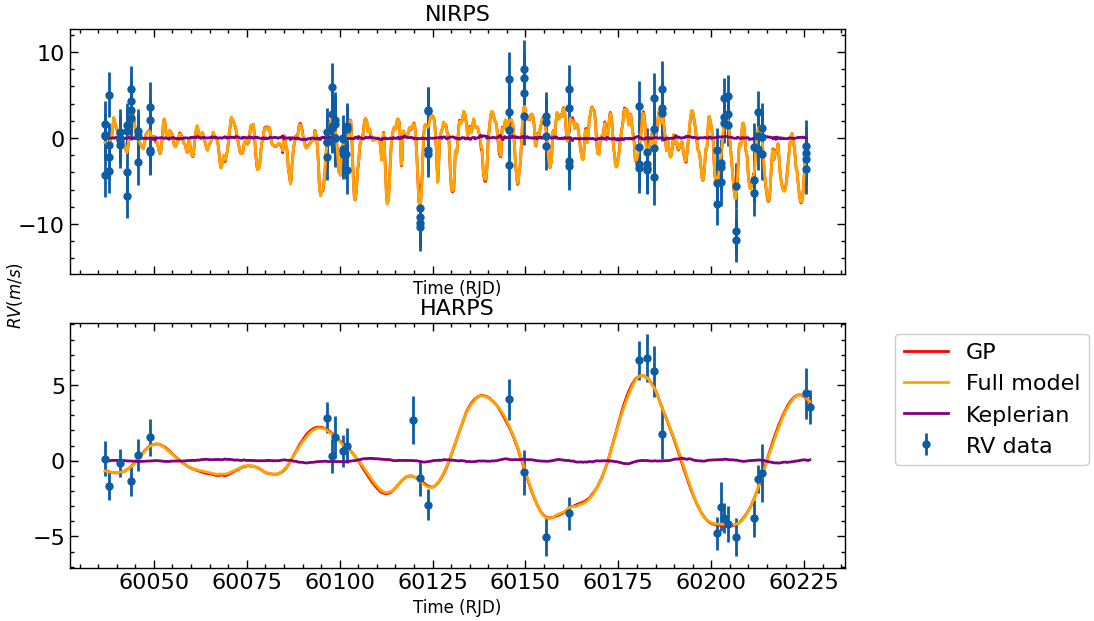

In [ ]:
for instrument in instruments: 
    # Times
    min_time, max_time = np.min(data.times_rv[instrument]), np.max(data.times_rv[instrument])
    model_times = np.linspace(min_time,max_time,1000)

    # GP model
    full_model, components = results.rv.evaluate(instrument, t = model_times, GPregressors = model_times, return_components = True) # Keplerian model
    gp = results.rv.model[instrument]['GP'] # GP model
    
    mu = np.median(results.posteriors['posterior_samples']['mu_' + instrument])  # Mean
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_' + instrument])  # White noise
    
    # Plotting
    if len(instruments)==1: 
        axes.errorbar(t_rv[instrument], y_rv[instrument]-mu,
                      yerr=np.sqrt(yerr_rv[instrument]**2+jitter**2),
                      fmt='o', label = f'RV data')
        axes.plot(model_times, gp, label = f'GP',color='red')
        axes.plot(model_times, full_model, label = f'Full model', color='orange')
        axes.plot(model_times, full_model - gp, label = f'Keplerian', color='purple')
        axes.set_xlabel("Time (RJD)", fontsize = 12)
        axes.set_title(f"{instrument}")
    else:
        axes[i].errorbar(t_rv[instrument], y_rv[instrument]-mu,
                      yerr=np.sqrt(yerr_rv[instrument]**2+jitter**2),
                      fmt='o', label = f'RV data')
        axes[i].plot(model_times, gp, label = f'GP',color='red')
        axes[i].plot(model_times, full_model, label = f'Full model', color='orange')
        axes[i].plot(model_times, full_model - gp, label = f'Keplerian', color='purple')
        axes[i].set_xlabel("Time (RJD)", fontsize = 12)
        axes[i].set_title(f"{instrument}")

    i+=1

plt.legend(bbox_to_anchor=(1.05,1))
fig.text(0.06, 0.5, r'$RV (m/s)$', fontsize =12, va='center', rotation='vertical')

plt.savefig(f'stars/{star}/juliet/output_{star}_2_GP/{star}_2_GP_curve.png')
plt.show()

# Parameter Name           Median         .1   Upper 68 CI    .2  \
0    P_p1                         10.562357            1.219352       
1    K_p1                          0.092167            0.220093       
2    t0_p1                     60153.114186           10.400553       
3    P_p2                         69.590023           13.800173       
4    K_p2                          0.013774            0.148444       
5    t0_p2                     60155.622229            4.661410       
6    GP_Prot_NIRPS                 5.322389            3.549862       
7    GP_sigma_NIRPS                5.650747            3.778095       
8    GP_alpha_NIRPS                0.000383            0.000112       
9    GP_Gamma_NIRPS                2.118432            2.466227       
10   GP_Prot_HARPS                43.541284            4.185645       
11   GP_sigma_HARPS                3.879254            3.416838       
12   GP_alpha_HARPS                0.000136            0.000157       
13   GP_Gamma_HARPS                1.726253            1.125795       

     Lower 68 CI   
0        0.904704  
1        0.057927  
2        5.965677  
3       28.359169  
4        0.010431  
5        6.625437  
6        0.956138  
7        1.773066  
8        0.000161  
9        1.309570  
10       2.296416  
11       1.300296  
12       0.000069  
13       1.072281

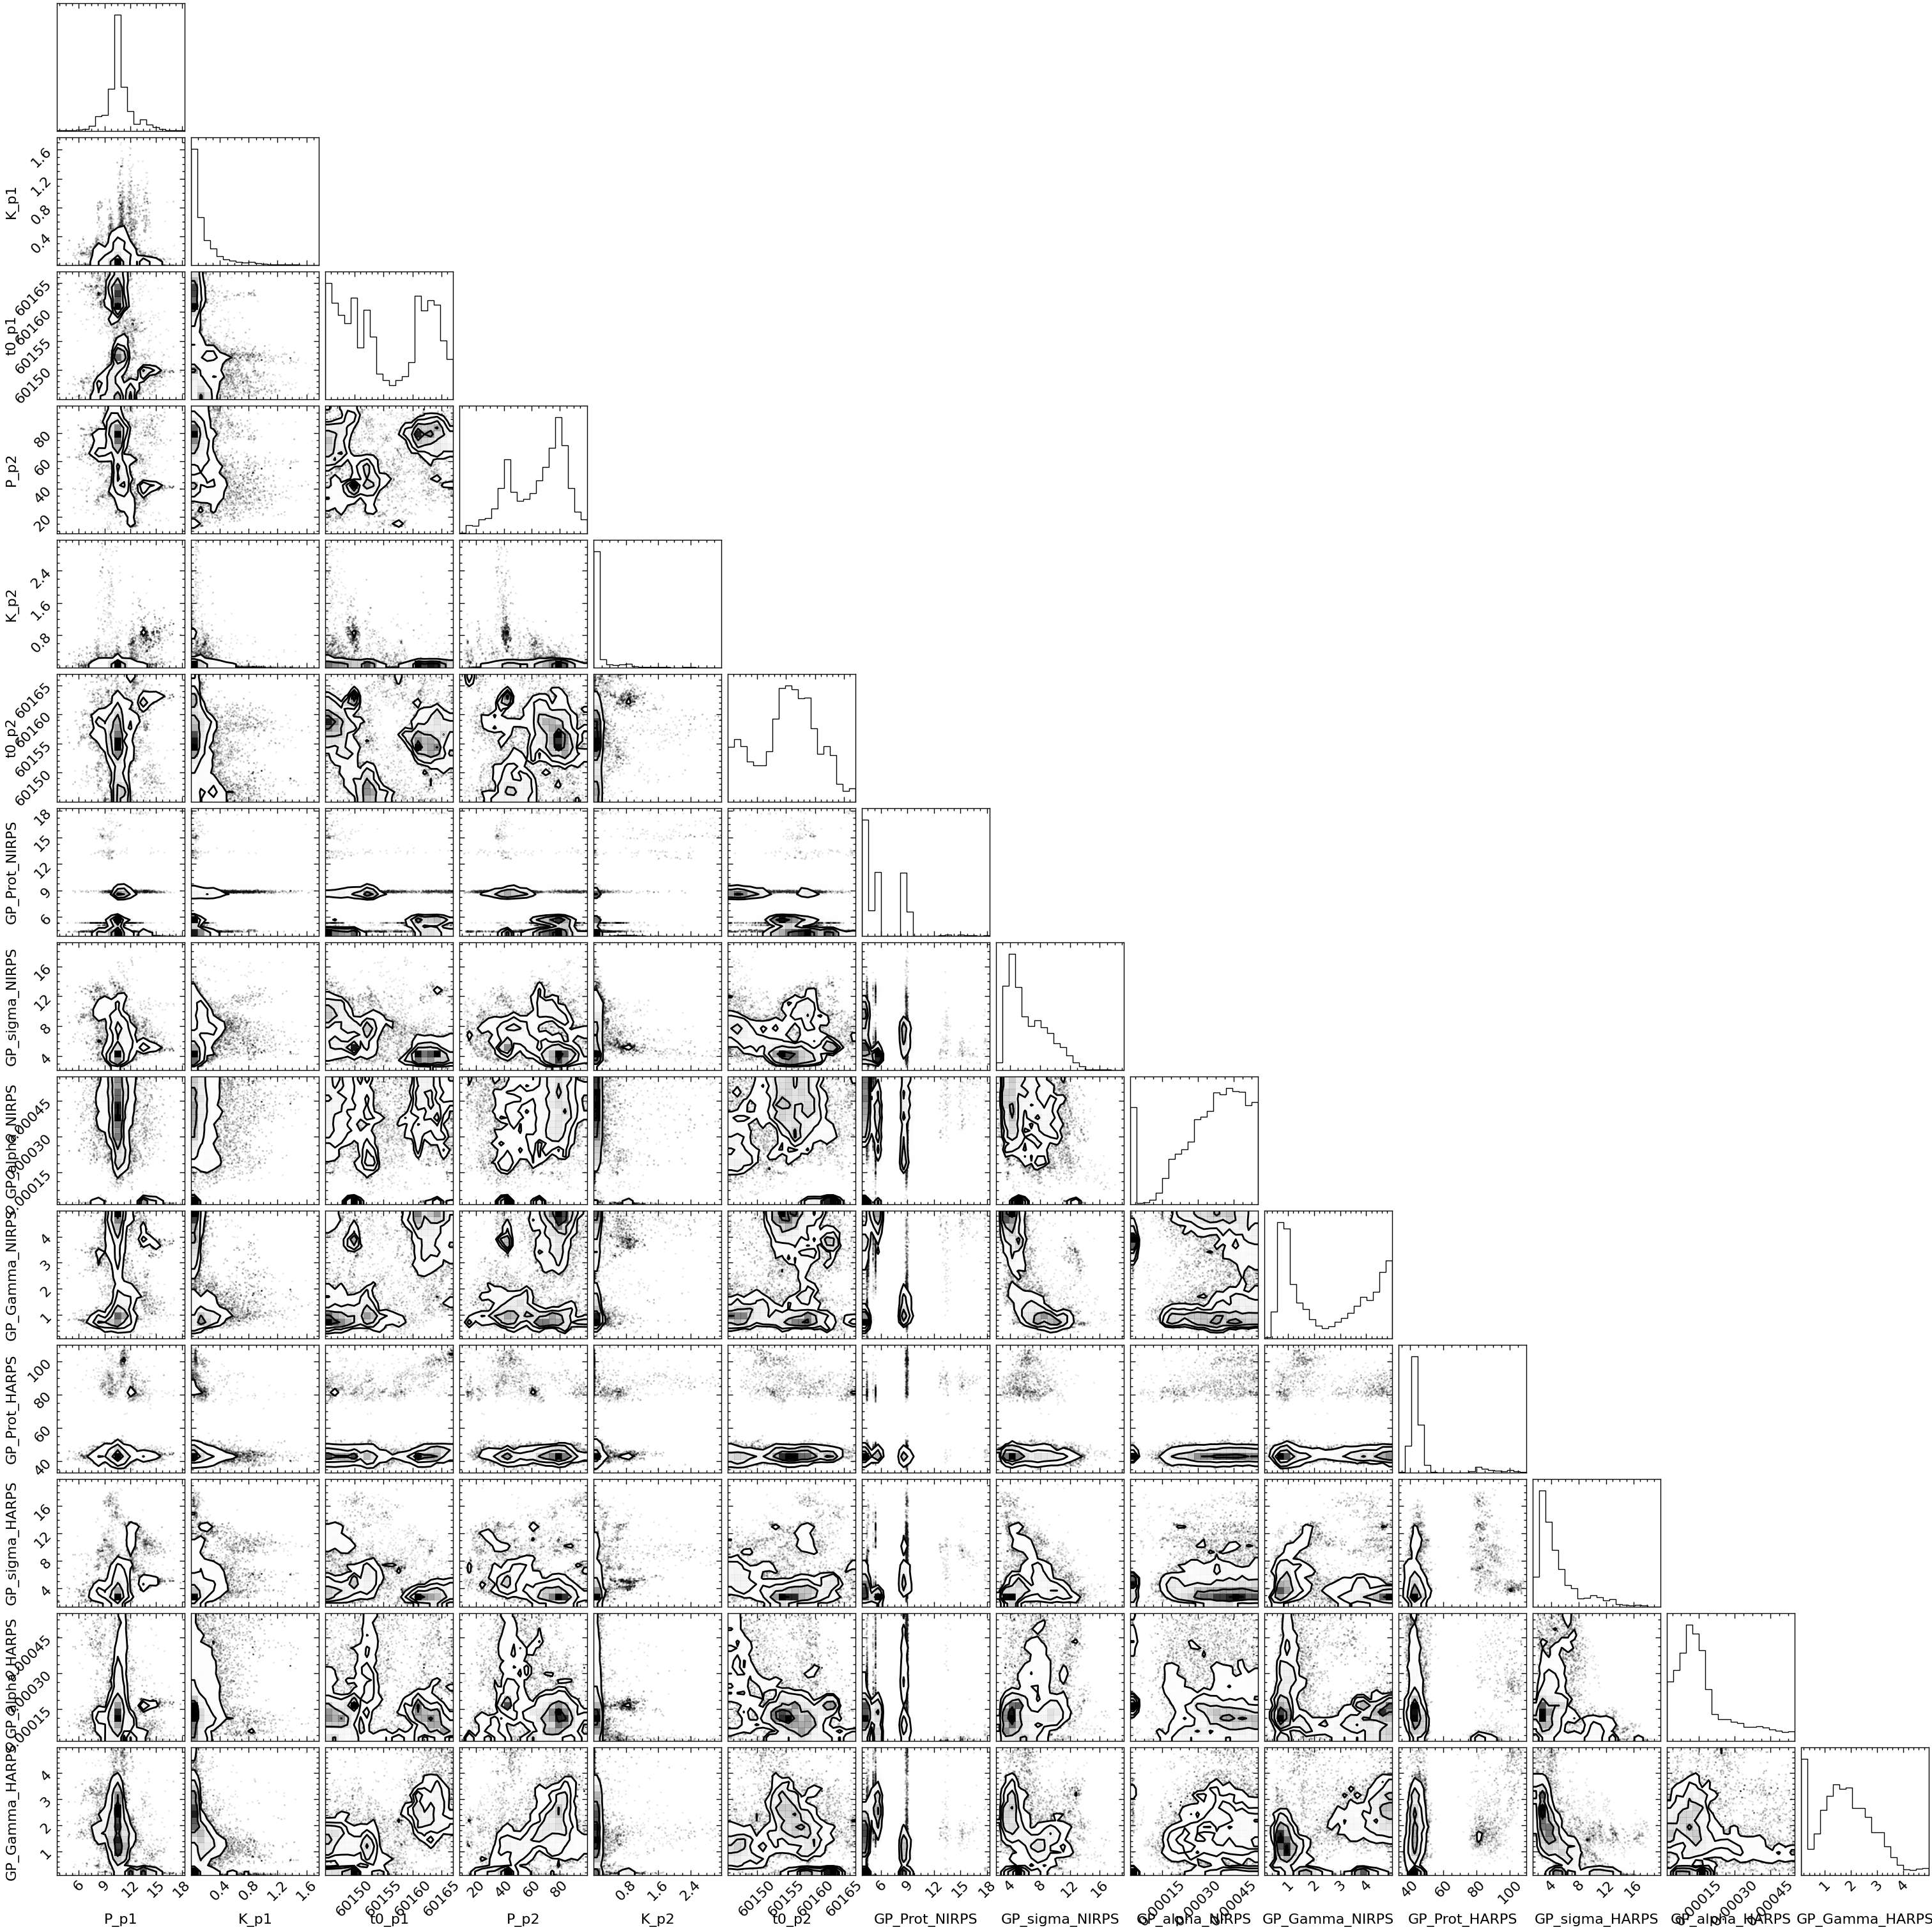

In [ ]:
posterior_names = ['P_p1', 'K_p1', 't0_p1'] + ['P_p2', 'K_p2', 't0_p2'] +  params_GP
    
first_time = True
for i in range(len(params)):
    if dists[i] != 'fixed' and 'mu' not in params[i] and 'w' not in params[i] and \
    params[i][0:2] != 'mu' and params[i][0:5] != 'sigma':
        if first_time:
            posterior_data = results.posteriors['posterior_samples'][params[i]]
            first_time = False
        else:
            posterior_data  = np.vstack((posterior_data, results.posteriors['posterior_samples'][params[i]]))
posterior_data = posterior_data.T
figure = corner.corner(posterior_data, labels = posterior_names)
plt.savefig('stars/{}/juliet/output_{}_2_GP/{}_2_GP_corner.png'.format(star, star, star))

print(posteriors)

In [ ]:
print('ALL DONE!')